# Chicago Crime Data

# Initialize Data

## Import Necessary Libraries

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
import math
from math import ceil
from pandas import option_context
import joblib

# Map Libraries
import geopandas as gpd
from shapely import Point #, Polygon 

#import tick customization tools
import matplotlib.ticker as mticks

# Permanently changes the pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 7)

## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
from sklearn import set_config
set_config(display='diagram')

## Load the Data

In [2]:
# Import street map for graphing
street_map = gpd.read_file('Data/Chicago/Boundaries-PoliceBeats/geo_export_8c74fa94-8f74-4ab4-844b-277eef61cdea.shp')

In [3]:
# Import the data
path = 'Data/Chicago/Crimes_-_2001_to_2023.csv'

df_OE = pd.read_csv(path)
df_OE.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
0,13345615,JH124875,01/01/2024 12:00:00 AM,0000X E 112TH PL,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,531,5.0,9.0,49.0,14,1178433.0,1830383.0,2024,01/24/2024 03:41:43 PM,41.689873,-87.622377,"(41.689873321, -87.62237719)",30.0,21861.0,45.0,253.0,43.0,19.0,10.0,265.0,11.0
1,13344137,JH123152,01/01/2024 12:00:00 AM,082XX S SPAULDING AVE,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,RESIDENCE,False,False,834,8.0,18.0,70.0,11,1155815.0,1849869.0,2024,01/23/2024 03:40:54 PM,41.743829,-87.704662,"(41.743828816, -87.70466174)",6.0,4300.0,69.0,199.0,30.0,8.0,13.0,232.0,18.0
2,13344111,JH122919,01/01/2024 12:00:00 AM,076XX S HONORE ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,611,6.0,17.0,71.0,11,1165343.0,1854075.0,2024,01/23/2024 03:40:54 PM,41.755174,-87.669631,"(41.755174364, -87.669631279)",17.0,21554.0,70.0,573.0,31.0,59.0,20.0,231.0,17.0


In [4]:
# create copy in memory so dataframe does not need to be reimported to rerun cells below
df = df_OE.copy()

In [5]:
# verify successful concatenation combination
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7974704 entries, 0 to 7974703
Data columns (total 31 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   ID                          int64  
 1   Case Number                 object 
 2   Date                        object 
 3   Block                       object 
 4   IUCR                        object 
 5   Primary Type                object 
 6   Description                 object 
 7   Location Description        object 
 8   Arrest                      bool   
 9   Domestic                    bool   
 10  Beat                        int64  
 11  District                    float64
 12  Ward                        float64
 13  Community Area              float64
 14  FBI Code                    object 
 15  X Coordinate                float64
 16  Y Coordinate                float64
 17  Year                        int64  
 18  Updated On                  object 
 19  Latitude             

## Functions

In [6]:
def thousands(x,pos):
    """ function for use with matplotlib FuncFormatter:  
        formats numbers in thousands"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"

In [7]:
def K_delim(x):
    ''' function formats float values with thousands separator (,) and 
        ZERO decimal places'''
    return f"{x:,.0f}"

In [8]:
def K_delim_2(x):
    ''' function formats float values with thousands separator (,) and  
        TWO decimal places'''
    return f"{x:,.2f}"

In [9]:
def PT_value_update(feature_name, change_to, change_from):
    ''' function takes three arguments: a single column and two of its values.  
        it then replaces all "change_from" values with "change_to" values. '''
    
    # create a mask for target value & previous value
    mask_from = df[feature_name] == change_from
    mask_to = df[feature_name] == change_to

    # show count of previous values and then combined values (with thousands separators)
    print(f"Initial number of {change_from} values: {K_delim(mask_from.sum())}") 
    print(f"Initial number of {change_to} values: {K_delim(mask_to.sum())}") 

    print("______________________________________________________")

    # update to new value
    df.loc[mask_from, feature_name] = change_to

    # recount target value to check update was successful 
    mask_from_after = df[feature_name] == change_from
    mask_to_after = df[feature_name] == change_to
    print(f"Updated number of {change_from} values: {K_delim(mask_from_after.sum())}") 
    print(f"Updated number of {change_to} values: {K_delim(mask_to_after.sum())}") 

    print("______________________________________________________")

    # verify updated totals
    print(f"{K_delim(mask_from.sum())} + {K_delim(mask_to.sum())} = {K_delim(mask_from.sum() + mask_to.sum())}")
    if (mask_from.sum() + mask_to.sum()) == mask_to_after.sum():
        print("Totals match updated values: Success!")
    else:
        print("Totals do not match. Check calculations!!!") 

In [10]:
''' print functions used in Location/Latitude/Longitude comparison/cleaning '''

# sets the left justified starting point in character spaces
desired_width = 25   

# print function for displaying items with a "last" value
def my_print(name, value):

    #print(f"{name}: {value}")
    print(f"Last value of   {name.ljust(desired_width)} {list(value)[-1]}")
    print(f"Var type of     {name.ljust(desired_width)} {type(value)}")
    print(f"Length of       {name.ljust(desired_width)} {len(value)}")
    print("________________________________________________________________")

# print function for blank/empty values
def my_print_0_length(name, value):

    print(f"Value of        {name.ljust(desired_width)} {value}")
    print(f"Var type of     {name.ljust(desired_width)} {type(value)}")
    print(f"Length of       {name.ljust(desired_width)} {len(value)}")
    print("________________________________________________________________")

# print function to print out a variable's name and value, only
def my_print_nv(name, value):

    print(f"Value of {name}: {value}")

# Prepare DataFrame

## Create datetime format index

In [11]:
# Examine single row for format of Date feature
test_date = df.loc[0, 'Date']
test_date

'01/01/2024 12:00:00 AM'

In [12]:
# Check 'Date' for null values
df['Date'].isna().sum()

0

In [13]:
# Create a column in datetime format
df['CrimeDateTime'] = pd.to_datetime(df['Date'], format= '%m/%d/%Y %I:%M:%S %p', errors = 'coerce')

# Set datetime column as the index
df = df.set_index('CrimeDateTime')

# Order index according to ascending date order
df = df.sort_index(axis = 0)

df.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,JG467702,01/01/2001 12:00:00 AM,045XX N CENTRAL PARK AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,33.0,14.0,02,NaN,NaN,2001,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01,1369398,G076100,01/01/2001 12:00:00 AM,017XX W SCHOOL ST,1120,DECEPTIVE PRACTICE,FORGERY,OTHER,False,False,1924,19.0,NaN,NaN,10,1164115.0,1921915.0,2001,08/17/2015 03:03:40 PM,41.941360,-87.672218,"(41.941359919, -87.67221762)",16.0,4449.0,57.0,742.0,18.0,22.0,5.0,19.0,32.0
2001-01-01,1322043,G003560,01/01/2001 12:00:00 AM,061XX S ARTESIAN AV,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,825,8.0,NaN,NaN,14,1161130.0,1863925.0,2001,08/17/2015 03:03:40 PM,41.782292,-87.684799,"(41.782292325, -87.684798685)",44.0,21867.0,64.0,111.0,2.0,58.0,13.0,274.0,16.0


In [14]:
# Drop previous "Date" feature as the index has replaced it 
df = df.drop(columns = 'Date')
df.head(3)

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,JG467702,045XX N CENTRAL PARK AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,33.0,14.0,02,NaN,NaN,2001,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01,1369398,G076100,017XX W SCHOOL ST,1120,DECEPTIVE PRACTICE,FORGERY,OTHER,False,False,1924,19.0,NaN,NaN,10,1164115.0,1921915.0,2001,08/17/2015 03:03:40 PM,41.941360,-87.672218,"(41.941359919, -87.67221762)",16.0,4449.0,57.0,742.0,18.0,22.0,5.0,19.0,32.0
2001-01-01,1322043,G003560,061XX S ARTESIAN AV,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,825,8.0,NaN,NaN,14,1161130.0,1863925.0,2001,08/17/2015 03:03:40 PM,41.782292,-87.684799,"(41.782292325, -87.684798685)",44.0,21867.0,64.0,111.0,2.0,58.0,13.0,274.0,16.0


## Drop Duplicates
We will check for and drop any duplicates to remove any identical information as our initial step for data cleaning, now that we have setup our index.

In [15]:
# check for duplicates
print('Number of Duplicated Rows:', df.duplicated().sum())

Number of Duplicated Rows: 0


No duplicates were found to remove.

## Drop Rows/Observations Outside of Range

We will not be including any information after the year 2023, but to ensure no data was skipped in the last 15 minutes of 2023, data through 2024-01-01 at 12:00am was included. Data in 2024 will be dropped.

In [16]:
date_to_drop = pd.to_datetime('2024-01-01')

display(df.loc[df.index == date_to_drop])

df = df.loc[df.index != date_to_drop]
display(df)

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-01,13325121,JH100358,122XX S SANGAMON ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,524,5.0,21.0,53.0,08B,1172208.0,1823718.0,2024,01/08/2024 03:59:56 PM,41.671722,-87.645362,"(41.671722201, -87.64536182)",45.0,22212.0,50.0,662.0,22.0,13.0,10.0,220.0,21.0
2024-01-01,13326256,JH101535,066XX S MARQUETTE RD,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,321,3.0,20.0,42.0,14,1180716.0,1861074.0,2024,01/08/2024 03:59:56 PM,41.774041,-87.613079,"(41.774041094, -87.613078903)",53.0,22260.0,9.0,332.0,4.0,60.0,18.0,206.0,20.0
2024-01-01,13325491,JH100906,030XX N ALBANY AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,1411,14.0,35.0,21.0,14,1155187.0,1919914.0,2024,01/08/2024 03:59:56 PM,41.936053,-87.705086,"(41.936053288, -87.705085514)",15.0,21538.0,22.0,465.0,20.0,39.0,7.0,174.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,13329004,JH103625,097XX S LOWE AVE,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,2223,22.0,9.0,73.0,05,1173688.0,1840323.0,2024,01/08/2024 03:59:56 PM,41.717256,-87.639455,"(41.717256314, -87.639455463)",18.0,21861.0,72.0,593.0,22.0,19.0,9.0,243.0,11.0
2024-01-01,13325994,JH101383,036XX S WOLCOTT AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,912,9.0,12.0,59.0,06,1164283.0,1880493.0,2024,01/08/2024 03:59:56 PM,41.827691,-87.672772,"(41.827691054, -87.672772029)",26.0,14924.0,56.0,720.0,1.0,37.0,23.0,165.0,12.0
2024-01-01,13345615,JH124875,0000X E 112TH PL,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,531,5.0,9.0,49.0,14,1178433.0,1830383.0,2024,01/24/2024 03:41:43 PM,41.689873,-87.622377,"(41.689873321, -87.62237719)",30.0,21861.0,45.0,253.0,43.0,19.0,10.0,265.0,11.0


,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,13246664,JG467702,045XX N CENTRAL PARK AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,33.0,14.0,02,NaN,NaN,2001,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 00:00:00,1369398,G076100,017XX W SCHOOL ST,1120,DECEPTIVE PRACTICE,FORGERY,OTHER,False,False,1924,19.0,NaN,NaN,10,1164115.0,1921915.0,2001,08/17/2015 03:03:40 PM,41.941360,-87.672218,"(41.941359919, -87.67221762)",16.0,4449.0,57.0,742.0,18.0,22.0,5.0,19.0,32.0
2001-01-01 00:00:00,1322043,G003560,061XX S ARTESIAN AV,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,825,8.0,NaN,NaN,14,1161130.0,1863925.0,2001,08/17/2015 03:03:40 PM,41.782292,-87.684799,"(41.782292325, -87.684798685)",44.0,21867.0,64.0,111.0,2.0,58.0,13.0,274.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:51:00,13324997,JH100010,009XX E 77TH ST,0530,ASSAULT,AGGRAVATED - OTHER DANGEROUS WEAPON,APARTMENT,False,True,624,6.0,8.0,69.0,04A,1183685.0,1854148.0,2023,01/08/2024 03:59:56 PM,41.754967,-87.602411,"(41.754966726, -87.602410989)",9.0,21546.0,67.0,497.0,35.0,61.0,20.0,227.0,10.0
2023-12-31 23:51:00,13325009,JH100002,051XX S PRINCETON AVE,0550,ASSAULT,AGGRAVATED POLICE OFFICER - HANDGUN,STREET,True,False,935,9.0,20.0,37.0,04A,1175152.0,1871065.0,2023,01/17/2024 03:41:31 PM,41.801584,-87.633177,"(41.801583507, -87.633177068)",12.0,14924.0,3.0,224.0,9.0,37.0,23.0,117.0,20.0
2023-12-31 23:59:00,13327763,JH103488,010XX N ORLEANS ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,1823,18.0,27.0,8.0,14,1173727.0,1907173.0,2023,01/08/2024 03:59:56 PM,41.900698,-87.637330,"(41.900698378, -87.637329754)",41.0,14926.0,37.0,148.0,46.0,54.0,14.0,51.0,27.0


We have successfully dropped all observations that occurred in 2024.

## Remove Unnecessary Features

### Ward 
The Ward feature is an independent variable but highly correlates with both District and Beat. This feature will be dropped, for both this reason and that the boundaries are also not consistent over time:

"Ward boundaries change after each United States census in order to reflect population shifts within the city and to ensure that each ward has approximately the same population." Source: 

https://www.chicago.gov/city/en/depts/dgs/supp_info/citywide_maps.html 

In [17]:
# drop Ward
df = df.drop(columns=['Ward'])
df.head(1)

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,JG467702,045XX N CENTRAL PARK AVE,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,14.0,02,NaN,NaN,2001,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Block 
The Block feature will be viewed as another unnecessary and redundant location feature. It could potentially be used to locate missing latitude & longitude coordinates, but that could be potentially assessed in the future. We will drop the feature for now. 

In [18]:
# drop Block
df = df.drop(columns=['Block'])
df.head(1)

,ID,Case Number,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,JG467702,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,14.0,02,NaN,NaN,2001,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Community Area
The Community Area feature will also be viewed as another unnecessary and redundant location feature. In the same way as Block, this feature could also be used in the future. We will drop it for now.

Community Area reference map: 

https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

In [19]:
# drop Community Area
df = df.drop(columns=['Community Area'])
df.head(1)

,ID,Case Number,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,JG467702,0281,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,02,NaN,NaN,2001,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### IUCR
This feature's name is short for Illinois Uniform Crime Reporting codes. This feature is the exact same information that is in the Description feature, but in numerical form. This feature will be dropped. Reference: 

https://data.cityofchicago.org/widgets/c7ck-438e

In [20]:
# drop IUCR
df = df.drop(columns=['IUCR'])
df.head(1)

,ID,Case Number,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,JG467702,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,02,NaN,NaN,2001,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### FBI Code
The FBI Code feature used in this dataset does not appear to align with the NIBRS Offense Codes listed on the FBI's website. This feature will be dropped. NIBRS Offense Codes reference: 

https://ucr.fbi.gov/nibrs/2011/resources/nibrs-offense-codes

In [21]:
# drop FBI Code
df = df.drop(columns=['FBI Code'])
df.head(1)

,ID,Case Number,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,JG467702,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,NaN,NaN,2001,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Year
The Year feature is now redundant as our index is in datetime format. This feature will be dropped. 

In [22]:
# drop Year
df = df.drop(columns=['Year'])
df.head(1)

,ID,Case Number,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,X Coordinate,Y Coordinate,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,JG467702,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,NaN,NaN,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Case Number
We can see below that Case Number is not completely unique in the dataset (so it cannot be used in place of an index) but has high cardinality/dimensionality. We will drop this feature to reduce both dimensionality and redundancy.

In [23]:
# Verify if Case Number has only unique values: It does not.
print(f"The number of unique values in Case Number is:  {df['Case Number'].nunique()}")
print(f"The number of rows in the dataframe is:         {len(df)}")
print(f"The number of non-unique Case Number values is: {len(df) - df['Case Number'].nunique()}")

The number of unique values in Case Number is:  7974100
The number of rows in the dataframe is:         7974655
The number of non-unique Case Number values is: 555


In [24]:
# drop Case Number
df = df.drop(columns=['Case Number'])
df.head(1)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,X Coordinate,Y Coordinate,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,NaN,NaN,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### X & Y Coordinates
Both the X Coordinate and the Y Coordinate fields are based on a map entitled "State Plane Illinois East NAD 1983 projection," that we will not be using for our purposes. This feature will be dropped. Reference: 

https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp/data

In [25]:
# drop X & Y Coordinates
df = df.drop(columns=['X Coordinate', 'Y Coordinate'])
df.head(1)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Updated On,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,10/21/2023 03:42:03 PM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Updated On 
This feature shows when information about the case was last updated. For our purposes using this dataset, we will not use this feature and it will be dropped. 

In [26]:
# drop Updated On
df = df.drop(columns=['Updated On'])
df.head(1)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Location vs. Latitude & Longitude
1) The values for both Location, as well as the value pairs Latitude & Longitude, appear to include the same values (Location has the separate Latitude & Longitude values combined into a single value/tuple). This needs to be verified.

2) It should also be checked if there are any instances where one set of value pairs has information that the other set is missing (Latitude & Longitude vs Location). If so, the field could be imputed using the correlating values. 

3) Finally, once both systems have been updated and verified, then only one system should be kept, whichever suits our use best. As Tableau will be used for further data analysis, we will choose to use the separated Latitude & Longitude features for their ease of use. 

The Location feature will be dropped.

#### Verify Data Types before Comparison (Location vs. Latitude & Longitude)
Determine the data types of Location and Latitude/Longitude to see if type conversion/casting will be necessary before being able to compare the values for equivalency. 

In [27]:
# see how many Location observations have a coordinate value, print
not_null_loc = df['Location'].notnull()
print(not_null_loc.value_counts())

# display the first five observations where Location has a coordinate value
df.loc[not_null_loc == True].head()

True     7886766
False      87889
Name: Location, dtype: int64


,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,
2001-01-01,1369398,DECEPTIVE PRACTICE,FORGERY,OTHER,False,False,1924,19.0,41.941360,-87.672218,"(41.941359919, -87.67221762)",16.0,4449.0,57.0,742.0,18.0,22.0,5.0,19.0,32.0
2001-01-01,1322043,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,825,8.0,41.782292,-87.684799,"(41.782292325, -87.684798685)",44.0,21867.0,64.0,111.0,2.0,58.0,13.0,274.0,16.0
2001-01-01,1310724,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,825,8.0,41.782030,-87.690891,"(41.782030175, -87.690891368)",44.0,21867.0,64.0,111.0,2.0,58.0,13.0,274.0,16.0
2001-01-01,1318802,THEFT,$500 AND UNDER,RESIDENCE,False,True,532,5.0,41.667824,-87.622155,"(41.66782394, -87.622155017)",30.0,21861.0,50.0,504.0,43.0,19.0,10.0,219.0,11.0
2001-01-01,1310541,BATTERY,SIMPLE,RESIDENCE,False,False,421,4.0,41.753316,-87.563985,"(41.753316255, -87.563985474)",43.0,22538.0,39.0,246.0,37.0,24.0,19.0,225.0,5.0


In [28]:
# display the first row above using the ID of the first observation with a Location value 
not_null_loc1 = df.loc[df['ID'] == 1369398]
display(not_null_loc1)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,
2001-01-01,1369398,DECEPTIVE PRACTICE,FORGERY,OTHER,False,False,1924,19.0,41.94136,-87.672218,"(41.941359919, -87.67221762)",16.0,4449.0,57.0,742.0,18.0,22.0,5.0,19.0,32.0


In [29]:
# using that first row, display the value and value type of Location
display(not_null_loc1['Location'][0])
type(not_null_loc1['Location'][0])

# the value looks like a tuple, but is actually a string 

'(41.941359919, -87.67221762)'

str

In [30]:
# Check the specific Latitude value for that first observation
display(not_null_loc1['Latitude'][0])
# Check Latitude value type
display(type(not_null_loc1['Latitude'][0]))

# Latitude is a floating decimal value. We will convert it to string to compare with Location.

# Convert type to string
display(str(not_null_loc1['Latitude'][0]))
# Verify now of type string
display(type(str(not_null_loc1['Latitude'][0])))

41.941359919

numpy.float64

'41.941359919'

str

In [31]:
# how a trailing zero is handled when converted to a string.
str(-87.704271320)

'-87.70427132'

#### DataFrame for Testing (Location vs. Latitude & Longitude)
Create a smaller dataframe for testing purposes 

In [32]:
# Create a copy of the first specified number of rows 
df_copy = df.iloc[:125].copy()
print(len(df_copy))

# display with options 
# Source: https://stackoverflow.com/questions/20937538/how-to-display-pandas-dataframe-of-floats-using-a-format-string-for-columns
with pd.option_context('display.float_format', '{:,.9f}'.format):
    display(df_copy)

125


,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01,1369398,DECEPTIVE PRACTICE,FORGERY,OTHER,False,False,1924,19.000000000,41.941359919,-87.672217620,"(41.941359919, -87.67221762)",16.000000000,"4,449.000000000",57.000000000,742.000000000,18.000000000,22.000000000,5.000000000,19.000000000,32.000000000
2001-01-01,1322043,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,825,8.000000000,41.782292325,-87.684798685,"(41.782292325, -87.684798685)",44.000000000,"21,867.000000000",64.000000000,111.000000000,2.000000000,58.000000000,13.000000000,274.000000000,16.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-01-01,4735908,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,2424,24.000000000,42.015277064,-87.683161926,"(42.015277064, -87.683161926)",3.000000000,"22,528.000000000",10.000000000,52.000000000,5.000000000,12.000000000,11.000000000,33.000000000,49.000000000
2001-01-01,6655075,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,False,True,712,7.000000000,41.789052743,-87.653679331,"(41.789052743, -87.653679331)",19.000000000,"21,559.000000000",66.000000000,409.000000000,2.000000000,11.000000000,17.000000000,261.000000000,16.000000000
2001-01-01,6742268,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,True,612,6.000000000,41.755090605,-87.652502144,"(41.755090605, -87.652502144)",17.000000000,"21,554.000000000",70.000000000,572.000000000,31.000000000,59.000000000,20.000000000,230.000000000,17.000000000


#### Global Variables for Comparison Functions (Location vs. Latitude & Longitude)
Select with dataframe to use, determine its length. 
Select how many Percent of Progress Completed lines to display & size of each slice, between.

In [33]:
''' Global Variables '''

# select which dataframe to use
#which_df = df_copy    # df_copy (for testing)
which_df = df    # df (full dataset)

# save length of dataframe to a variable
dflength = len(which_df)

# control total number of progress indicator printout lines
total_progress_print_lines = 72

# use in progress functions
progress_interval = int(dflength/total_progress_print_lines)  

#### Functions used in Comparison (Location vs. Latitude & Longitude)
The functions below are called from the main function that follows them. 

They check every Location observation to see if it has a value, and if so, compares it to the corresponding Latitude & Longitude values to check for equivalency. If the Location and Latitude/Longitude values are not equivalent (missing or different), a list will be returned with the indexes where there are discrepancies.

In [34]:
# create iterable list with index (int) and bool if Location has a value or not
def idx_value_list():
    idxs_values = [(idx, value) for idx, value in enumerate(which_df['Location'].notnull())]
    my_print('idxs_values', idxs_values)
    return idxs_values

In [35]:
# print a progress percentage update with index
def print_progress_lines(idx):
    value = "{:.0f}".format((idx/dflength)*100)
    value = f"{value}%" 
    print(f"\nProgress:       {value}      (idx: {idx})") 

In [36]:
# print initial progress of 0%
def progress_lines_init(idx):

    print_progress_lines

In [37]:
# print progress update at calculated step rate
def progress_lines(idx):

    if (idx+1) % progress_interval == 0:
        print_progress_lines(idx)

In [38]:
# create a class to keep track of what "percentage" has been completed between Progress Update Lines printed
class SharedDotState:  # classes use PascalCase instead of snake_case
    def __init__(self):
        # initialize tracking set to contain ints between 0 & 99
        self.encountered_integers = set()

    # for testing, print all current values in set
    def print_set(self):
        print(self.encountered_integers)

    # empty all values in set 
    def reset_set(self):
        self.encountered_integers = set()

    # test if modulo/"percentage" is in set, print progress if new "percentage" is found & increment
    def increment_set(self, modulo):
        
        # modulo will return a value from 0 to including 99
        modulo = modulo % 100

        # reset tracking set when starting to "climb the ladder" again from 0 (to avoid duplicate "pings")
        if modulo == 0 and 99 in self.encountered_integers:
            dot_state.reset_set()

        # print to progress bar if new "percentage" detected, add "percentage" to tracking set
        if modulo not in self.encountered_integers:
            print(".", end='', flush=True)
            self.encountered_integers.add(modulo)
                        
# instantiate class              
dot_state = SharedDotState()
dot_state.print_set()
dot_state.increment_set(modulo=0)
dot_state.reset_set()


set()
.

In [39]:
# calculate approximate "percentage" of progress between each Progress Update line/step
def progress_dots(idx):  

        # calculate "percentage" 
        iter_progress = math.floor((idx) / progress_interval * 100)

        # pass "percentage" to check if it has been "seen" yet. print an update if it is new. 
        dot_state.increment_set(iter_progress)

In [40]:
# tests for equivalency between Latitude & Longitude values and Location via string casting
def string_casting_comp(idx_value):

    idx = idx_value[0]       # grabs first value of tuple (idx/index)
    value = idx_value[1]     # grabs second value of tuple (boolean)
    
    try:

        '''Progress Indicator'''
        progress_dots(idx)
        progress_lines(idx)


        '''Run primary part of function'''
        not_equivalent = None    # return None when df['Location'] is null 

        # if Location has a value, compare to Lat. & Long.
        if value:

            # grab Lat, Long, Loc
            gL_Lat, gL_Long, gL_Loc = which_df.iloc[idx][['Latitude', 'Longitude', 'Location']]
            
            # stringify Lat. & Long.
            gL_Lat_str = str(gL_Lat)
            gL_Long_str = str(gL_Long)
                        
            # concatenate Lat. & Long. to match Location's form 
            gL_LL_str = f"({gL_Lat_str}, {gL_Long_str})"

            # compare string values
            if gL_LL_str != gL_Loc:
                not_equivalent = True        # Implies Location has a value that Lat & Long do not.
            else:                            
                not_equivalent = False       # Implies Location and Lat & Long have the same information.
            
            # return index value and boolean (only True if there is a discrepancy) 
            return idx, not_equivalent        
    
    except TimeoutError as e:
        print("The function string_casting_comp timed out.")
        print(e)
        not_equivalent = None

    except Exception as e:
        print("String comparison error!")
        print(e)
        not_equivalent = None

In [41]:
# uses a map function to compare equivalency (Lat/Long to Loc) for each observation 
def not_equiv(idxs_values):
    
    not_equiv_list = list(map(string_casting_comp, idxs_values))   
    print()
    my_print('not_equiv_list', not_equiv_list)
    return not_equiv_list

In [42]:
# when Location has no initial value, None is returned. This removes all None values.
def remove_Nones(not_equiv_list):

    # counts number of Nones in returned list
    none_count_str = 'not_equiv_list'
    none_count = 0
    for item in not_equiv_list:
        if item is None:
            none_count += 1

    print(f'Total Nones in  {none_count_str.ljust(desired_width)} {none_count}')

    # adds only values that are NOT None to a new list
    not_equiv_NN_list = list()
    for result in not_equiv_list:
        if result is not None:
           not_equiv_NN_list.append(result) 

    my_print('not_equiv_NN_list', not_equiv_NN_list)

    # returns new list with all None values removed
    return not_equiv_NN_list    

In [43]:

# returns True if Location has any values that are missing or different from Lat/Long
def true_index_list(not_equiv_list):

    true_indexes = [index for index, condition in not_equiv_list if condition]

    my_print_0_length('true_indexes', true_indexes)
    print(f"If true_indexes remains an empty list, then every value in Location is already in Latitude & Longitude.")
    print(f"If true_indexes has any True values, then there are some values in Location not in Latitude & Longitude.")
    print(f"Any True references found should have Location values copied (to Latitude & Longitude) before it's dropped.")
    
    return true_indexes

#### Main Function used in Comparison (Location vs. Latitude & Longitude)
The main function calls the associated functions above to determine if all Location values match those found in Latitude/Longitude.

In [44]:
def main():

    # create iterable with index and bool if Location has a value
    idxs_values = idx_value_list()

    # initialize Progress Indicator display
    print('Progress Indicator:')

    # print initial progress of 0%
    idx_value_init = idxs_values[0] 
    progress_lines_init(idx_value_init[0])
    
    # pass iterable to a map function along with an equivalency comparison function
    not_equiv_list = not_equiv(idxs_values)   # returns True if Lat & Long not equivalent to Location

    # removes values with None (designating where Location had no initial value)
    not_equiv_NN_list = remove_Nones(not_equiv_list)
    
    # only saves index values where Lat & Long values are different from Location's (missing or different)
    true_indexes = true_index_list(not_equiv_NN_list)

    # return list to serialize results if needed, after processing
    return true_indexes # , not_equiv_NN_list

# Execute main function
true_indexes = main()  

Last value of   idxs_values               (7974654, True)
Var type of     idxs_values               <class 'list'>
Length of       idxs_values               7974655
________________________________________________________________
Progress Indicator:
.......

.............................................................................................
Progress:       1%      (idx: 110758)
....................................................................................................
Progress:       3%      (idx: 221517)
....................................................................................................
Progress:       4%      (idx: 332276)
....................................................................................................
Progress:       6%      (idx: 443035)
....................................................................................................
Progress:       7%      (idx: 553794)
....................................................................................................
Progress:       8%      (idx: 664553)
....................................................................................................
Progress:       10%      (idx: 775312)
.................................

In [45]:
# access the results from the main function
# true_indexes = _540
print(true_indexes)

[]


#### Summary of Comparison (Location vs. Latitude & Longitude)
We can see that true_indexes list that was returned from the main function, was an empty list. We have verified both Points 1 & 2 from the beginning of this section:

1) Location contains *equivalent values* found in Latitude & Longitude
2) Location does **not** contain any values *not already found in* Latitude & Longitude

We are now ready to proceed to Point 3:

3) **Drop Location** as it either has redundant (or less) information than Latitude & Longitude.

In [46]:
# drop Location
df = df.drop(columns=['Location'])
df.head(1)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Wards 2023-
CrimeDateTime,,,,,,,,,,,,,,,,,,,
2001-01-01,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Additional Features 
The features now listed after the column "Longitude" were not present when the dataset was originally downloaded in August of 2023. While there is potential for additional analysis using these previously unavailable columns (perhaps in the future in a separate notebook), we will not include them at this time and drop them. 

In [47]:
# check feature index values for dropping in the next step
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7974655 entries, 2001-01-01 00:00:00 to 2023-12-31 23:59:00
Data columns (total 19 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   ID                          int64  
 1   Primary Type                object 
 2   Description                 object 
 3   Location Description        object 
 4   Arrest                      bool   
 5   Domestic                    bool   
 6   Beat                        int64  
 7   District                    float64
 8   Latitude                    float64
 9   Longitude                   float64
 10  Historical Wards 2003-2015  float64
 11  Zip Codes                   float64
 12  Community Areas             float64
 13  Census Tracts               float64
 14  Wards                       float64
 15  Boundaries - ZIP Codes      float64
 16  Police Districts            float64
 17  Police Beats                float64
 18  Wards 2023-                 f

In [48]:
# make a list of all columns after Longitude
cols_to_drop = df.columns[10:18 +1].tolist()

# drop all columns in list
df.drop(columns=cols_to_drop, inplace=True)
display(df)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude
CrimeDateTime,,,,,,,,,,
2001-01-01 00:00:00,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17.0,NaN,NaN
2001-01-01 00:00:00,1369398,DECEPTIVE PRACTICE,FORGERY,OTHER,False,False,1924,19.0,41.941360,-87.672218
2001-01-01 00:00:00,1322043,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,825,8.0,41.782292,-87.684799
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:51:00,13324997,ASSAULT,AGGRAVATED - OTHER DANGEROUS WEAPON,APARTMENT,False,True,624,6.0,41.754967,-87.602411
2023-12-31 23:51:00,13325009,ASSAULT,AGGRAVATED POLICE OFFICER - HANDGUN,STREET,True,False,935,9.0,41.801584,-87.633177
2023-12-31 23:59:00,13327763,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,1823,18.0,41.900698,-87.637330


All features after Longitude have been removed so that we can use the updated dataset with the cleaning and EDA processes previously established, below.

## Handle Null Values & Verify Data Types

In [49]:
# Find total number of observations (7,974,655)
print(f"{K_delim(len(df))}")

7,974,655


Find all null values in the dataframe.

In [50]:
# Find all null values in dataframe
with pd.option_context('display.max_rows', None):
    print(df.isnull().sum())

ID                          0
Primary Type                0
Description                 0
Location Description    12385
Arrest                      0
Domestic                    0
Beat                        0
District                   47
Latitude                87889
Longitude               87889
dtype: int64


Address how each set of NaN will be handled:
* Location Description: update to the value 'Other'
* District: Use 'Beat' to find value via correlation OR **drop**
* Lat/Long/Location: *ignore*

### Location Description
We will replace the Null values with the generic 'Other' value that already exists in that feature.

In [51]:
# Count the number of null values in feature.
LD_null_before = df['Location Description'].isnull().sum()
print(f"{K_delim(LD_null_before)}")

12,385


In [52]:
# Count number of values for 'Other' that currently exist.
LD_Other_before = df['Location Description'].value_counts()['OTHER']
print(f"{K_delim(LD_Other_before)}")

270,016


In [53]:
# Replace Null values with 'Other'
df['Location Description'].fillna('OTHER', inplace=True)

In [54]:
# Count number of values for 'Other' after converting null values.
LD_Other_after = df['Location Description'].value_counts()['OTHER']
print(f"{K_delim(LD_Other_after)}")

282,401


In [55]:
# Verify increase in the count of 'Other' values in Location Description.
spacer = ''
left_space = 2

print(f"Count of 'Other' BEFORE converting Null values:               {spacer.ljust(left_space)} {K_delim(LD_Other_before)}")
print(f"Count of 'Other' AFTER converting Null values:                {spacer.ljust(left_space)} {K_delim(LD_Other_after)}")
print(f"Increased number of 'Other' values in 'Location Description':  {spacer.ljust(left_space)} {K_delim(LD_Other_after - LD_Other_before)}")
print(f"Original number of Null values in 'Location Description':      {spacer.ljust(left_space)} {K_delim(LD_null_before)}")
print(f"Remaining Null values in 'Location Description':                    {spacer.ljust(left_space)} {K_delim(df['Location Description'].isnull().sum())}")

Count of 'Other' BEFORE converting Null values:                  270,016
Count of 'Other' AFTER converting Null values:                   282,401
Increased number of 'Other' values in 'Location Description':     12,385
Original number of Null values in 'Location Description':         12,385
Remaining Null values in 'Location Description':                       0


All Null values in Location Description have successfully been replaced with the value 'OTHER'.

### District
We will use the 'Beat' feature to see if a correlating 'District' value can be discovered,  otherwise drop any of the initial 47 observations that remain unresolved (still having Null values) (as the unresolved number is insignificant).

Note: Beats are subsections of Districts and can be used to determine the missing District value.
Note Source: https://interactive.wbez.org/maps/police-districts-wards/

In [56]:
# Count of Null values in District
df['District'].isnull().sum()

47

In [57]:
# Verify a value for the Beat of each observation with a Null District value
D_null_mask = df['District'].isnull()   # create a mask for only Null District values 
D_null_rows = df[D_null_mask]           # create copy of the filtered/masked data

D_beat_rows = D_null_rows[['ID', 'Beat', 'District', 'Primary Type']]  # show basic info where District is Null

print(D_beat_rows.sort_values(by='Beat'))

                          ID  Beat  District     Primary Type
CrimeDateTime                                                
2004-10-14 15:41:00  3596991   124       NaN         BURGLARY
2006-05-10 19:40:00  4740376   124       NaN          BATTERY
2008-10-10 23:57:00  6585169   234       NaN          ASSAULT
...                      ...   ...       ...              ...
2008-10-24 17:45:00  6580306  2531       NaN  CRIMINAL DAMAGE
2008-10-27 19:14:20  6580316  2532       NaN          ASSAULT
2008-11-01 16:10:00  6588015  2535       NaN            THEFT

[47 rows x 4 columns]


In [58]:
# Check if there is any correlation between a particular Beat and District: there is.
series_beat_124 = df[df['Beat'] == 124]['District'].value_counts()           # save value counts to Series
series_beat_124.index = [f"District {K_delim(label)}" for label in series_beat_124.index]  # format index of Series
display(series_beat_124)

District 1     21850
District 18        2
District 31        1
Name: District, dtype: int64

We can see above that for Beat 124, all but three corresponding District values are the same (District 1). There is a good chance that the other District values returned (18 & 31) are not correct. We will leave these potential entry errors for now as they are insignificant, but may come back to look more closely at them later.

In [59]:
# Create a list of unique values for each Beat corresponding to a Null District value.
D_beats = D_beat_rows['Beat'].unique()  # returns an array of unique Beat values
D_beats_sorted = sorted(D_beats)        # sorts the Beat values, ascending

D_beats_sorted_inline = ', '.join(map(str, D_beats_sorted))    # join to display in single line/string
print(D_beats_sorted_inline)

124, 234, 311, 312, 313, 411, 513, 621, 712, 723, 731, 734, 823, 831, 922, 1013, 1112, 1113, 1132, 1323, 1333, 1423, 1424, 1433, 1624, 1654, 1722, 1814, 1834, 1912, 1924, 1931, 2232, 2412, 2511, 2514, 2523, 2531, 2532, 2535


In [60]:
# Explore correlation by looking up each Beat in the list. Look at the District (and its counts) that corresponds the best.
for x in D_beats_sorted: 

    # counts how many times a District is associated with a particular Beat 
    series_beat = df[df['Beat'] == x]['District'].value_counts()   

    # reformat index of District counts to be able to extract first/top result 
    series_beat.index = [f"{K_delim(label)}" for label in series_beat.index]

    # extract first/top District result for each Beat
    series_count = series_beat.head(1)

    print(f"- Beat {x}    correlates (with counts) to    District {series_count} \n")

- Beat 124    correlates (with counts) to    District 1    21850
Name: District, dtype: int64 

- Beat 234    correlates (with counts) to    District 2    23793
Name: District, dtype: int64 

- Beat 311    correlates (with counts) to    District 3    20379
Name: District, dtype: int64 

- Beat 312    correlates (with counts) to    District 3    40558
Name: District, dtype: int64 

- Beat 313    correlates (with counts) to    District 3    35344
Name: District, dtype: int64 

- Beat 411    correlates (with counts) to    District 4    32366
Name: District, dtype: int64 

- Beat 513    correlates (with counts) to    District 5    40740
Name: District, dtype: int64 

- Beat 621    correlates (with counts) to    District 6    48398
Name: District, dtype: int64 

- Beat 712    correlates (with counts) to    District 7    40706
Name: District, dtype: int64 

- Beat 723    correlates (with counts) to    District 7    33291
Name: District, dtype: int64 

- Beat 731    correlates (with counts) t

In [61]:
# Iterate over each row with a Null District value (UPDATE with new and most likely District value) 

# print column titles
print(f"ID       Beat# District")

# loop over rows with no value for District
for idx, value in enumerate(df['District'].isnull()):   # enumerate (creates a mask)
    
    # only update rows where it is True that District values are missing/null
    if value:    

        # BEFORE
        # Lookup the Beat (& ID) for associated Null-value District rows
        D_null_summary = df.iloc[idx][['ID', 'Beat', 'District']]        # collect summary info
        D_null_summary_inline = ', '.join(map(str, D_null_summary))      # display in single line format
        print(D_null_summary_inline)                                     # print
        
        # UPDATE 
        # Lookup current Beat & find the most highly correlated District, 
        # grab associated District value & update current row's District value [row index of 7]. 
        df.iloc[idx, 7] = df[df['Beat'] == df.iloc[idx]['Beat']]['District'].value_counts().index[0] 
        
        # AFTER
        # Lookup the Beat (& ID) to verify new value for District in each row 
        D_null_summary = df.iloc[idx][['ID', 'Beat', 'District']]        # collect summary info
        D_null_summary_inline = ', '.join(map(str, D_null_summary))      # display in single line format
        print(D_null_summary_inline)                                     # print
        print("________________________________________________________________")

ID       Beat# District
3575885, 1834, nan
3575885, 1834, 18.0
________________________________________________________________
3596991, 124, nan
3596991, 124, 1.0
________________________________________________________________
4437079, 1834, nan
4437079, 1834, 18.0
________________________________________________________________
4740376, 124, nan
4740376, 124, 1.0
________________________________________________________________
6420740, 922, nan
6420740, 922, 9.0
________________________________________________________________
6405961, 2232, nan
6405961, 2232, 22.0
________________________________________________________________
6420058, 513, nan
6420058, 513, 5.0
________________________________________________________________
6376239, 1112, nan
6376239, 1112, 11.0
________________________________________________________________
6576124, 1834, nan
6576124, 1834, 18.0
________________________________________________________________
6462999, 311, nan
6462999, 311, 3.0
________________

Some features are currently float values, but should be of type integer.

We will update the *District* feature to have only integer values.

(Note: *ID* & *Beat* are already integer values as verified in the df.info shown below.)

In [62]:
# display data type for each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7974655 entries, 2001-01-01 00:00:00 to 2023-12-31 23:59:00
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                bool   
 5   Domestic              bool   
 6   Beat                  int64  
 7   District              float64
 8   Latitude              float64
 9   Longitude             float64
dtypes: bool(2), float64(3), int64(2), object(3)
memory usage: 562.8+ MB


In [63]:
# Update District values to type integer
df['District'] = df['District'].astype(int)

print(df['District'])

CrimeDateTime
2001-01-01 00:00:00    17
2001-01-01 00:00:00    19
2001-01-01 00:00:00     8
                       ..
2023-12-31 23:51:00     6
2023-12-31 23:51:00     9
2023-12-31 23:59:00    18
Name: District, Length: 7974655, dtype: int64


In [64]:
# verify that District is now of data type integer 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7974655 entries, 2001-01-01 00:00:00 to 2023-12-31 23:59:00
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                bool   
 5   Domestic              bool   
 6   Beat                  int64  
 7   District              int64  
 8   Latitude              float64
 9   Longitude             float64
dtypes: bool(2), float64(2), int64(3), object(3)
memory usage: 562.8+ MB


We can see that #7 District has been successfully updated and is now of type Integer (int64). 

## Remove Invalid Information

### Latitude 
When this data was previously visualized using Tableau, it was noticed that there was at least one major outlier completely outside of the region of Chicago. The outlier Latitude value noted was: '36.619446395'.

We will need to check for, and verify, any other outliers (below 40° based on graphing in Tableau and also the graph below) to ensure that only valid Chicago Crime data is included.

We will use a box plot to statistically identify outliers using the IQR proximity rule. 

Source: https://medium.com/swlh/identify-outliers-with-pandas-statsmodels-and-seaborn-2766103bf67c

* First quartile = Q1 = midpoint of the lower half of the data set
* Median = Q2 = midpoint of the distribution
* Third quartile = Q3 = midpoint of the upper half of the data set

* IQR = interquartile range = Q3 - Q1

* The upper boundary = Q3 + (1.5 * IQR)
* The lower boundary = Q1 - (1.5 * IQR)

Outlier = any value outside the range between the lower and upper boundaries, represented by a dot on a boxplot.

Text(0.5, 1.0, 'Distribution of Latitude')

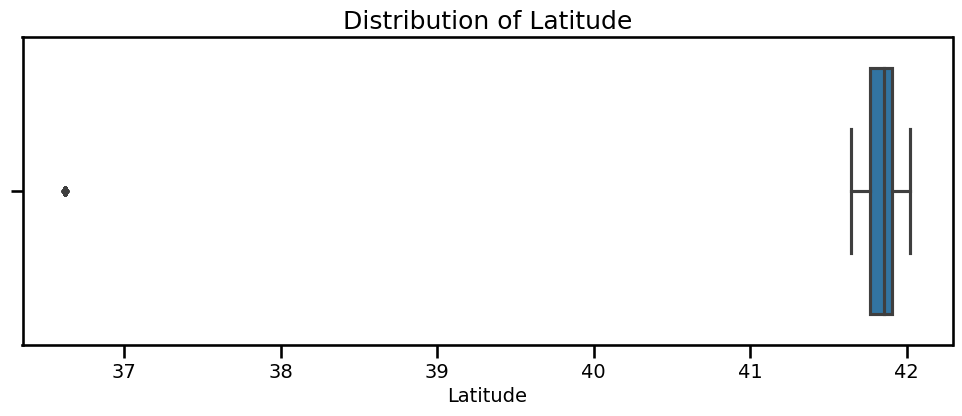

In [65]:
# box plot of Latitude
ax = sns.boxplot(x='Latitude', data=df)

# format graph's display (xtick, label, title)
plt.xticks(fontsize=14)
plt.xlabel('Latitude', fontsize=14)
plt.title('Distribution of Latitude', fontsize = 18)

There appears to be at least one outlier for Latitude (represented by the dot on the left side of the graph above), around 36°/37°. We will need to filter to handle as many outliers as there might be. 

In [66]:
outlier_lats = df[df['Latitude'] < 41.5]['Latitude'].value_counts()
outlier_lats.index = [f"{label:.3f}" for label in outlier_lats.index]

print(f"Total Latitude values below 41.5°: {outlier_lats.sum()}\n")

print("Individual count for each Latitude value found:")
with pd.option_context('display.max_rows', None):
    print(f"{outlier_lats}")

Total Latitude values below 41.5°: 149

Individual count for each Latitude value found:
36.619    149
Name: Latitude, dtype: int64


### Longitude

We will also use a box plot on Longitude to look for outliers.

Text(0.5, 1.0, 'Distribution of Longitude')

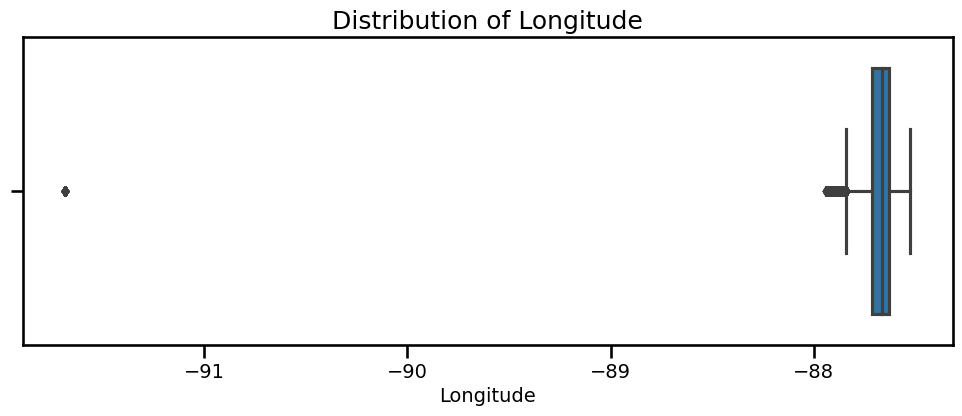

In [67]:
# box plot of Longitude
ax = sns.boxplot(x='Longitude', data=df)

# xtick, label, title
plt.xticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.title('Distribution of Longitude', fontsize=18)

There appears to be at least one very clear outlier for Longitude, at almost -92°. There are also a number of other "outliers" just below 88° that butt-up against the main section of the box plot; these values, while "outliers," do look to be contiguous with the bulk of the other Longitude values. These could potentially be located in a "peninsula" of Chicago, such as O'Hare International Airport (that juts West from the main part of the city area). We will leave the contiguous values for now, but will want to address the "-92°" value.

In [68]:
outlier_longs = df[df['Longitude'] < -88]['Longitude'].value_counts()
outlier_longs.index = [f"{label:.3f}" for label in outlier_longs.index]

print(f"Total Longitude values below -88°: {outlier_longs.sum()}\n")

print("Individual count for each Longitude value found:")
with pd.option_context('display.max_rows', None):
    print(f"{outlier_longs}")

Total Longitude values below -88°: 149

Individual count for each Longitude value found:
-91.687    149
Name: Longitude, dtype: int64


### Map Outliers

We will graph coordinates to visualize where the outliers are on a map.

<AxesSubplot: >

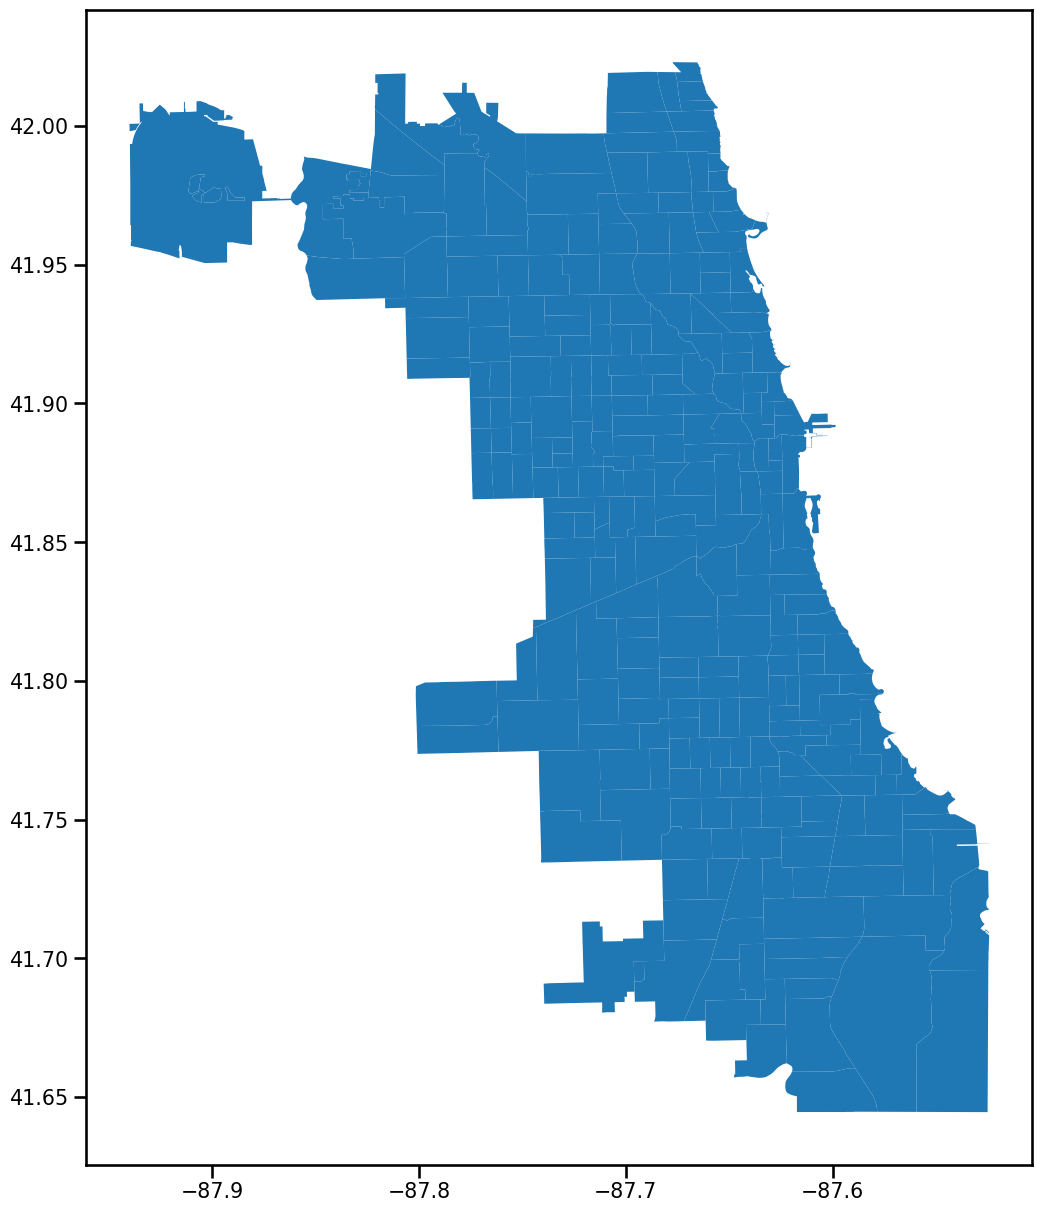

In [69]:
# display our unpopulated map of Chicago Police Beats 
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax)

In [70]:
# create a new column that will combine Lat & Long into Python plottable information 
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
print(geometry[:5])
print(f"{K_delim(len(geometry))}")

[<POINT (nan nan)>, <POINT (-87.7 41.9)>, <POINT (-87.7 41.8)>, <POINT (-87.7 41.8)>, <POINT (-87.6 41.7)>]
7,974,655


In [71]:
# specify the Coordinate Reference System that uses Latitude & Longitude as the metric 
crs = {'init':'epsg:4326'}

In [72]:
# create a new dataframe used only for map plotting
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
geo_df.head()

/Users/whitefreeze/anaconda3/envs/dojo-env/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,geometry
CrimeDateTime,,,,,,,,,,,
2001-01-01,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17,NaN,NaN,POINT (nan nan)
2001-01-01,1369398,DECEPTIVE PRACTICE,FORGERY,OTHER,False,False,1924,19,41.941360,-87.672218,POINT (-87.67222 41.94136)
2001-01-01,1322043,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,825,8,41.782292,-87.684799,POINT (-87.68480 41.78229)
2001-01-01,1310724,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,825,8,41.782030,-87.690891,POINT (-87.69089 41.78203)
2001-01-01,1318802,THEFT,$500 AND UNDER,RESIDENCE,False,True,532,5,41.667824,-87.622155,POINT (-87.62216 41.66782)


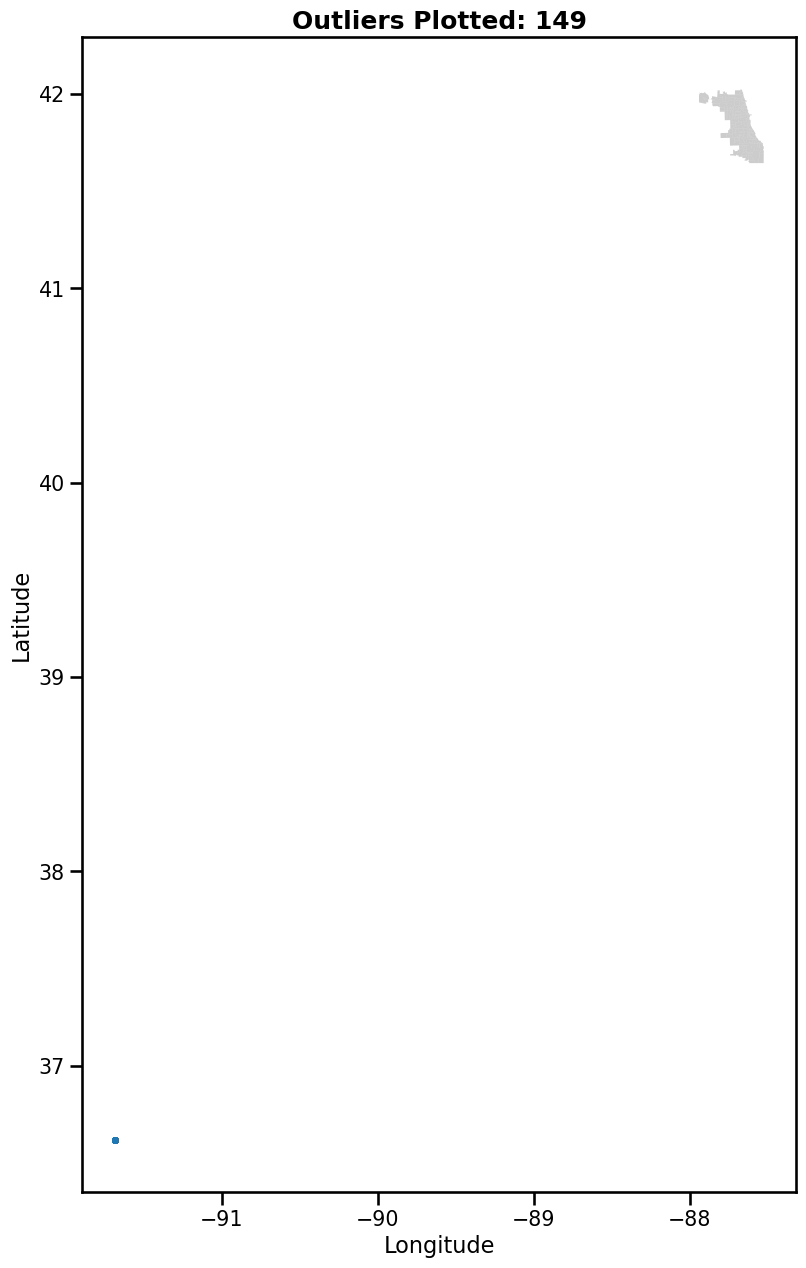

In [73]:
# Plot outliers
# create figure & axes, then assign to subplot
fig, ax = plt.subplots(figsize=(15,15))

# add shapefile map file to axes
street_map.plot(ax=ax, alpha=0.4, color='gray')

# create a mask to select only outliers for both Lat & Long
geo_outlier_mask_Lat = geo_df['Latitude'] < 41.5 
geo_outlier_mask_Long = geo_df['Longitude'] < -88

# combine masks and create new dataframe to plot outliers 
geo_outlier_mask = geo_outlier_mask_Lat | geo_outlier_mask_Long
geo_outliers = geo_df[geo_outlier_mask] 

# add geodataframe to axes
geo_outliers.plot(ax=ax, alpha=0.5, markersize=10)

# add title
plt.title(f'Outliers Plotted: {len(geo_outliers)}', fontsize=18, fontweight='bold')

# add axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude') 

# show map
plt.show()

In [74]:
# Check the number of unique values in the outliers
display(geo_outliers['Latitude'].value_counts())
display(geo_outliers['Longitude'].value_counts())

36.619446    149
Name: Latitude, dtype: int64

-91.686566    149
Name: Longitude, dtype: int64

We can see that all of our 149 outliers have only a single coordinate (36.619446, -91.686566). As there are only 149 (and unlikely to be able to impute a street-intersection-specific coordinate), we will remove the coordinate information for these outliers. We have seen in our graphed map above that these coordinates are clearly not in Chicago. However, we will only drop the Latitude & Longitude information from the outliers and keep the rest of the information. 

In [75]:
# Replace outlier Lat & Long values with the null value "NaN"

# show values before update
display(df.loc[geo_outlier_mask].head(3))

# use existing outlier mask to update values for outliers to NaN in df & geo_df
df.loc[geo_outlier_mask, ['Latitude', 'Longitude']] = np.nan
geo_df.loc[geo_outlier_mask, ['Latitude', 'Longitude']] = np.nan

# show values after update
display(df.loc[geo_outlier_mask].head(3))

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,geometry
CrimeDateTime,,,,,,,,,,,
2001-01-06 10:35:00,637,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2535,25,36.619446,-91.686566,POINT (-91.68657 36.61945)
2001-03-20 18:17:00,724,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,False,331,3,36.619446,-91.686566,POINT (-91.68657 36.61945)
2001-05-06 01:30:00,808,HOMICIDE,FIRST DEGREE MURDER,AUTO,True,False,915,9,36.619446,-91.686566,POINT (-91.68657 36.61945)


,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,geometry
CrimeDateTime,,,,,,,,,,,
2001-01-06 10:35:00,637,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2535,25,NaN,NaN,POINT (-91.68657 36.61945)
2001-03-20 18:17:00,724,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,False,331,3,NaN,NaN,POINT (-91.68657 36.61945)
2001-05-06 01:30:00,808,HOMICIDE,FIRST DEGREE MURDER,AUTO,True,False,915,9,NaN,NaN,POINT (-91.68657 36.61945)


In [76]:
# We can see that the geometry column will also need to be updated for both datasets
df.loc[geo_outlier_mask, 'geometry'] = np.nan 
geo_df.loc[geo_outlier_mask, 'geometry'] = np.nan 

# show values after update
display(df.loc[geo_outlier_mask].head(3))

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,geometry
CrimeDateTime,,,,,,,,,,,
2001-01-06 10:35:00,637,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2535,25,NaN,NaN,None
2001-03-20 18:17:00,724,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,True,False,331,3,NaN,NaN,None
2001-05-06 01:30:00,808,HOMICIDE,FIRST DEGREE MURDER,AUTO,True,False,915,9,NaN,NaN,None


We will show the box plots for Latitude & Longitude again to see what they should look like without any unreasonable outliers.

Text(0.5, 1.0, 'Distribution of Latitude')

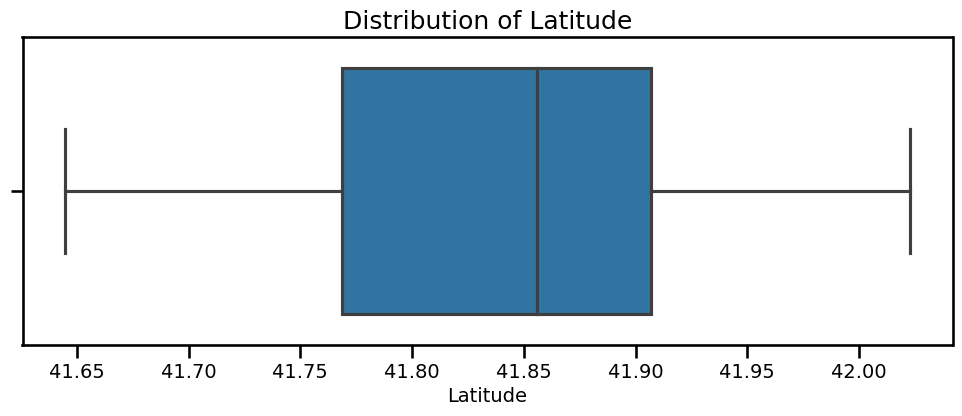

In [77]:
# box plot of Latitude
ax = sns.boxplot(x='Latitude', data=df)

# xtick, label, title
plt.xticks(fontsize=14)
plt.xlabel('Latitude', fontsize=14)
plt.title('Distribution of Latitude', fontsize = 18)

Text(0.5, 1.0, 'Distribution of Longitude')

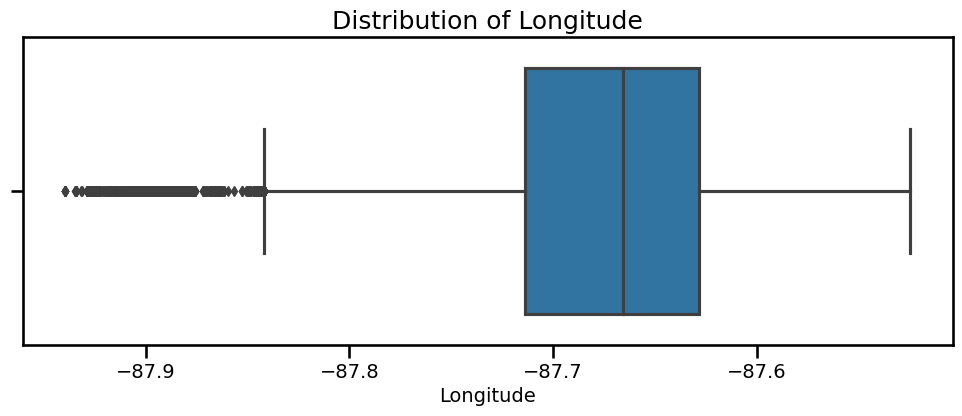

In [78]:
# box plot of Longitude
ax = sns.boxplot(x='Longitude', data=df)

# xtick, label, title
plt.xticks(fontsize=14)
plt.xlabel('Longitude', fontsize=14)
plt.title('Distribution of Longitude', fontsize=18)

Again, for the Longitude outliers (represented by dots on the left), these are contiguous with the other values and are most likely incidents at the O'Hare Airport, which is West from the main part of Chicago that we are dealing with.

We still need to remove the "geometry" column from the dataframe "df" as we still have the geo_outliers dataframe for any map graphing needs in this notebook (but want df cleaned and ready to export).

In [79]:
# Show that "geometry" column is still present in geo_df
geo_df.head(1)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,geometry
CrimeDateTime,,,,,,,,,,,
2001-01-01,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17,NaN,NaN,POINT (nan nan)


In [80]:
# Show that "geometry" column is still present in df, even though it isn't needed.
df.head(1)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude,geometry
CrimeDateTime,,,,,,,,,,,
2001-01-01,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17,NaN,NaN,POINT (nan nan)


In [81]:
# Drop "geometry" column from df
df.drop(columns='geometry', inplace=True)

In [82]:
# Verify column was successfully dropped
df.head(1)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude
CrimeDateTime,,,,,,,,,,
2001-01-01,13246664,CRIMINAL SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,1723,17,NaN,NaN


We successfully visually located all outliers through our map plot, determined whether outliers had relevant or irrelevant location data, then removed only the irrelevant location data from each observation. This was done for both datasets: df & geo_df. 

## Combine 'Primary Type' Values: Redundant or Similar 

In [83]:
# Display all crime types
df["Primary Type"].unique()

array(['CRIMINAL SEXUAL ASSAULT', 'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE',
       'THEFT', 'BATTERY', 'BURGLARY', 'OTHER OFFENSE',
       'OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE', 'ASSAULT',
       'CRIM SEXUAL ASSAULT', 'MOTOR VEHICLE THEFT', 'WEAPONS VIOLATION',
       'CRIMINAL TRESPASS', 'ROBBERY', 'NARCOTICS',
       'LIQUOR LAW VIOLATION', 'PUBLIC PEACE VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'STALKING', 'HOMICIDE',
       'GAMBLING', 'KIDNAPPING', 'PROSTITUTION', 'INTIMIDATION', 'ARSON',
       'RITUALISM', 'DOMESTIC VIOLENCE', 'OBSCENITY',
       'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL',
       'HUMAN TRAFFICKING', 'NON-CRIMINAL (SUBJECT SPECIFIED)',
       'NON - CRIMINAL'], dtype=object)

We can see a few of the Primary Type of crimes will need to be combined, because they are **1)** actually the same category, but spelled differently, **2)** in the same category of crime, or **3)** low enough in frequency to warrant combining with a somewhat similar category. This was done to increase overall readability and would be further improved from the input of a Subject Matter Expert. Currently, they are:

(Note: Average monthly occurrence rates have been added after each category. These averages are based on previous graphs of 2000-2019 crime trends and "acute guesstimation.")

> * NARCOTICS                      -         (not calculated)
> * OTHER NARCOTIC VIOLATION       -         (not calculated) 

> * NON-CRIMINAL                    -        (not calculated)
> * NON - CRIMINAL                  -        (not calculated)
> * NON-CRIMINAL (SUBJECT SPECIFIED)  -      (not calculated)

> * SEX OFFENSE ("Any sexual act against another") - 120/month
> * CRIM SEXUAL ASSAULT                         -    60/month
> * CRIMINAL SEXUAL ASSAULT                     -    60/month
> * OBSCENITY                                   -     4/month
> * PUBLIC INDECENCY                            -     1/month
> * HUMAN TRAFFICKING                           -     0.5/month
> * DOMESTIC VIOLENCE                           -     0.01/month

> * WEAPONS VIOLATION                           -   500/month
> * CONCEALED CARRY LICENSE VIOLATION           -    10/month

> * PUBLIC PEACE VIOLATION                      -   200/month 
> * INTERFERENCE WITH PUBLIC OFFICER            -    80/month

> * OFFENSE INVOLVING CHILDREN                  -   200/month
> * KIDNAPPING                                  -    40/month

> * OTHER OFFENSE                            -    1,800/month
> * LIQUOR LAW VIOLATION                     -       50/month
> * INTIMIDATION                             -       20/month
> * RITUALISM                                -        0.1/month

We will combine each of those sets into a single crime for more a more comprehensible analysis.

### Narcotics

We will combine: 
> * NARCOTICS        
> * OTHER NARCOTIC VIOLATION

In [84]:
# Replace 'Other Narcotic Violation' values with 'Narcotics'
PT_value_update('Primary Type', 'NARCOTICS', 'OTHER NARCOTIC VIOLATION')


Initial number of OTHER NARCOTIC VIOLATION values: 149
Initial number of NARCOTICS values: 751,325
______________________________________________________
Updated number of OTHER NARCOTIC VIOLATION values: 0
Updated number of NARCOTICS values: 751,474
______________________________________________________
149 + 751,325 = 751,474
Totals match updated values: Success!


All variations of NARCOTICS have been updated!

### Non-Criminal 

We will combine: 
> * NON-CRIMINAL  
> * NON - CRIMINAL 
> * NON-CRIMINAL (SUBJECT SPECIFIED) 

In [85]:
# Replace 'NON - CRIMINAL' values with 'NON-CRIMINAL'
PT_value_update('Primary Type', 'NON-CRIMINAL', 'NON - CRIMINAL')


Initial number of NON - CRIMINAL values: 38
Initial number of NON-CRIMINAL values: 184
______________________________________________________
Updated number of NON - CRIMINAL values: 0
Updated number of NON-CRIMINAL values: 222
______________________________________________________
38 + 184 = 222
Totals match updated values: Success!


In [86]:
# Replace 'NON-CRIMINAL (SUBJECT SPECIFIED)' values with 'NON-CRIMINAL'
PT_value_update('Primary Type', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)')


Initial number of NON-CRIMINAL (SUBJECT SPECIFIED) values: 9
Initial number of NON-CRIMINAL values: 222
______________________________________________________
Updated number of NON-CRIMINAL (SUBJECT SPECIFIED) values: 0
Updated number of NON-CRIMINAL values: 231
______________________________________________________
9 + 222 = 231
Totals match updated values: Success!


All variations of NON-CRIMINAL have been updated!

### Sex Offense

We will combine: 
> * SEX OFFENSE ("Any sexual act against another") - 120/month
> * CRIM SEXUAL ASSAULT                         -    60/month
> * CRIMINAL SEXUAL ASSAULT                     -    60/month
> * OBSCENITY                                   -     4/month
> * PUBLIC INDECENCY                            -     1/month
> * HUMAN TRAFFICKING                           -     0.5/month
> * DOMESTIC VIOLENCE                           -     0.01/month

In [87]:
# Replace 'CRIM SEXUAL ASSAULT' values with 'SEX OFFENSE'
PT_value_update('Primary Type', 'SEX OFFENSE', 'CRIM SEXUAL ASSAULT')


Initial number of CRIM SEXUAL ASSAULT values: 27,536
Initial number of SEX OFFENSE values: 31,798
______________________________________________________
Updated number of CRIM SEXUAL ASSAULT values: 0
Updated number of SEX OFFENSE values: 59,334
______________________________________________________
27,536 + 31,798 = 59,334
Totals match updated values: Success!


In [88]:
# Replace 'CRIMINAL SEXUAL ASSAULT' values with 'SEX OFFENSE'
PT_value_update('Primary Type', 'SEX OFFENSE', 'CRIMINAL SEXUAL ASSAULT')


Initial number of CRIMINAL SEXUAL ASSAULT values: 8,049
Initial number of SEX OFFENSE values: 59,334
______________________________________________________
Updated number of CRIMINAL SEXUAL ASSAULT values: 0
Updated number of SEX OFFENSE values: 67,383
______________________________________________________
8,049 + 59,334 = 67,383
Totals match updated values: Success!


In [89]:
# Replace 'OBSCENITY' values with 'SEX OFFENSE'
PT_value_update('Primary Type', 'SEX OFFENSE', 'OBSCENITY')


Initial number of OBSCENITY values: 842
Initial number of SEX OFFENSE values: 67,383
______________________________________________________
Updated number of OBSCENITY values: 0
Updated number of SEX OFFENSE values: 68,225
______________________________________________________
842 + 67,383 = 68,225
Totals match updated values: Success!


In [90]:
# Replace 'PUBLIC INDECENCY' values with 'SEX OFFENSE'
PT_value_update('Primary Type', 'SEX OFFENSE', 'PUBLIC INDECENCY')


Initial number of PUBLIC INDECENCY values: 199
Initial number of SEX OFFENSE values: 68,225
______________________________________________________
Updated number of PUBLIC INDECENCY values: 0
Updated number of SEX OFFENSE values: 68,424
______________________________________________________
199 + 68,225 = 68,424
Totals match updated values: Success!


In [91]:
# Replace 'HUMAN TRAFFICKING' values with 'SEX OFFENSE'
PT_value_update('Primary Type', 'SEX OFFENSE', 'HUMAN TRAFFICKING')


Initial number of HUMAN TRAFFICKING values: 103
Initial number of SEX OFFENSE values: 68,424
______________________________________________________
Updated number of HUMAN TRAFFICKING values: 0
Updated number of SEX OFFENSE values: 68,527
______________________________________________________
103 + 68,424 = 68,527
Totals match updated values: Success!


In [92]:
# Replace 'DOMESTIC VIOLENCE' values with 'SEX OFFENSE'
PT_value_update('Primary Type', 'SEX OFFENSE', 'DOMESTIC VIOLENCE')


Initial number of DOMESTIC VIOLENCE values: 1
Initial number of SEX OFFENSE values: 68,527
______________________________________________________
Updated number of DOMESTIC VIOLENCE values: 0
Updated number of SEX OFFENSE values: 68,528
______________________________________________________
1 + 68,527 = 68,528
Totals match updated values: Success!


All variations of SEX OFFENSE have been updated!

### Weapons Violation

We will combine: 
> * WEAPONS VIOLATION                           -   500/month
> * CONCEALED CARRY LICENSE VIOLATION           -    10/month

In [93]:
# Replace 'CONCEALED CARRY LICENSE VIOLATION' values with 'WEAPONS VIOLATION'
PT_value_update('Primary Type', 'WEAPONS VIOLATION', 'CONCEALED CARRY LICENSE VIOLATION')


Initial number of CONCEALED CARRY LICENSE VIOLATION values: 1,224
Initial number of WEAPONS VIOLATION values: 112,517
______________________________________________________
Updated number of CONCEALED CARRY LICENSE VIOLATION values: 0
Updated number of WEAPONS VIOLATION values: 113,741
______________________________________________________
1,224 + 112,517 = 113,741
Totals match updated values: Success!


All variations of WEAPONS VIOLATION have been updated!

### Public Peace Violation & Interference with Public Officer

We will combine: 
> * PUBLIC PEACE VIOLATION                      -   200/month 
> * INTERFERENCE WITH PUBLIC OFFICER            -    80/month

In [94]:
# Replace 'INTERFERENCE WITH PUBLIC OFFICER' values with 'PUBLIC PEACE VIOLATION'
PT_value_update('Primary Type', 'PUBLIC PEACE VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER')


Initial number of INTERFERENCE WITH PUBLIC OFFICER values: 18,791
Initial number of PUBLIC PEACE VIOLATION values: 52,948
______________________________________________________
Updated number of INTERFERENCE WITH PUBLIC OFFICER values: 0
Updated number of PUBLIC PEACE VIOLATION values: 71,739
______________________________________________________
18,791 + 52,948 = 71,739
Totals match updated values: Success!


PUBLIC PEACE VIOLATION and INTERFERENCE WITH PUBLIC OFFICER have been combined!

### Offense Involving Children

We will combine: 
> * OFFENSE INVOLVING CHILDREN                  -   200/month
> * KIDNAPPING                                  -    40/month

In [95]:
# Replace 'KIDNAPPING' values with 'OFFENSE INVOLVING CHILDREN'
PT_value_update('Primary Type', 'OFFENSE INVOLVING CHILDREN', 'KIDNAPPING')


Initial number of KIDNAPPING values: 7,325
Initial number of OFFENSE INVOLVING CHILDREN values: 57,111
______________________________________________________
Updated number of KIDNAPPING values: 0
Updated number of OFFENSE INVOLVING CHILDREN values: 64,436
______________________________________________________
7,325 + 57,111 = 64,436
Totals match updated values: Success!


All variations of OFFENSE INVOLVING CHILDREN have been updated.

### Other Offense

We will combine: 
> * OTHER OFFENSE                            -    1,800/month
> * LIQUOR LAW VIOLATION                     -       50/month
> * INTIMIDATION                             -       20/month
> * RITUALISM                                -        0.1/month

In [96]:
# Replace 'LIQUOR LAW VIOLATION' values with 'OTHER OFFENSE'
PT_value_update('Primary Type', 'OTHER OFFENSE', 'LIQUOR LAW VIOLATION')


Initial number of LIQUOR LAW VIOLATION values: 15,030
Initial number of OTHER OFFENSE values: 494,747
______________________________________________________
Updated number of LIQUOR LAW VIOLATION values: 0
Updated number of OTHER OFFENSE values: 509,777
______________________________________________________
15,030 + 494,747 = 509,777
Totals match updated values: Success!


In [97]:
# Replace 'INTIMIDATION' values with 'OTHER OFFENSE'
PT_value_update('Primary Type', 'OTHER OFFENSE', 'INTIMIDATION')


Initial number of INTIMIDATION values: 4,826
Initial number of OTHER OFFENSE values: 509,777
______________________________________________________
Updated number of INTIMIDATION values: 0
Updated number of OTHER OFFENSE values: 514,603
______________________________________________________
4,826 + 509,777 = 514,603
Totals match updated values: Success!


In [98]:
# Replace 'RITUALISM' values with 'OTHER OFFENSE'
PT_value_update('Primary Type', 'OTHER OFFENSE', 'RITUALISM')


Initial number of RITUALISM values: 24
Initial number of OTHER OFFENSE values: 514,603
______________________________________________________
Updated number of RITUALISM values: 0
Updated number of OTHER OFFENSE values: 514,627
______________________________________________________
24 + 514,603 = 514,627
Totals match updated values: Success!


All variations of OTHER OFFENSE have been updated!

In [99]:
df.tail()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Latitude,Longitude
CrimeDateTime,,,,,,,,,,
2023-12-31 23:50:00,13324881,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,923,9,41.800201,-87.691535
2023-12-31 23:50:00,13327752,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,122,1,41.886816,-87.631524
2023-12-31 23:51:00,13324997,ASSAULT,AGGRAVATED - OTHER DANGEROUS WEAPON,APARTMENT,False,True,624,6,41.754967,-87.602411
2023-12-31 23:51:00,13325009,ASSAULT,AGGRAVATED POLICE OFFICER - HANDGUN,STREET,True,False,935,9,41.801584,-87.633177
2023-12-31 23:59:00,13327763,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,1823,18,41.900698,-87.637330


# Exploratory Data Analysis EDA

## Comparing Police Districts:
Which district has the most crimes? Which has the least?


In [100]:
with pd.option_context('display.max_rows', 31):  # Display all rows returned

    # count crime for each District
    district_crime = df.groupby('District').size()

    # format output for readability
    district_crime = district_crime.reset_index().astype(int)  # new index as integer
    district_crime.set_index('District', inplace=True)  # use District as index
    district_crime.rename(columns={0: 'Crime Count'}, inplace=True)  # name column

    display(district_crime['Crime Count'].apply(K_delim))   # display w/thousands delimiter w/o saving value

District
1     325,047
2     378,219
3     404,232
4     452,714
5     352,586
6     466,411
7     458,098
8     535,478
9     388,929
10    343,423
11    510,275
12    397,090
14    308,093
15    339,714
16    267,528
17    230,335
18    358,901
19    359,583
20    141,665
21          4
22    260,938
24    241,983
25    453,159
31        250
Name: Crime Count, dtype: object

In [101]:
# get index/District with minimum and maximum crime count
min_idx = district_crime['Crime Count'].idxmin()
max_idx = district_crime['Crime Count'].idxmax()

my_print_nv('min_idx', min_idx)
my_print_nv('max_idx', max_idx)

Value of min_idx: 21
Value of max_idx: 8


In [102]:
# get crime counts of Districts with min and max crime 
min_val = district_crime['Crime Count'].min()
max_val = district_crime['Crime Count'].max()

# convert float to string value to display comma separator 
min_val_str = f'{min_val:,}'  
max_val_str = f'{max_val:,}'  

my_print_nv('min_val', min_val)
my_print_nv('max_val', max_val)
my_print_nv('min_val_str', min_val_str)
my_print_nv('max_val_str', max_val_str)

Value of min_val: 4
Value of max_val: 535478
Value of min_val_str: 4
Value of max_val_str: 535,478


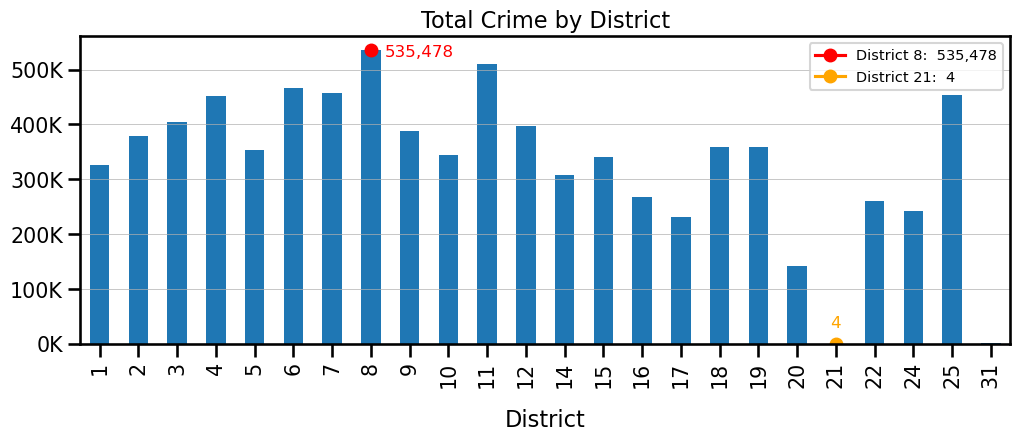

In [103]:
# Plot Total Crime by District
fig, ax = plt.subplots(figsize=(12,4))
district_crime.plot(ax=ax, kind='bar', title = 'Total Crime by District')

# Plot maximum crime point
ax.plot([max_idx-1],[max_val], marker='o', color = 'red')  # -1 to correct for no zero index
ax.text(max_idx -1 +.35, max_val -11000, max_val_str, fontsize=12, color='red')  # (+.35) & (-11000) to optimize readability 

## Plot minimum crime point
ax.plot([min_idx-2],[min_val], marker='o', color = 'orange')  # -2 to correct for no 13th District & no zero index
ax.text(min_idx -2 -.15, min_val +30000, min_val_str, fontsize=12, color='orange')  # (-.15) & (+30000) to optimize readability 

# Manually space x-axis label for readability 
plt.xlabel('District',labelpad=15)

# Create the number formatters
fmt_thous = mticks.FuncFormatter(thousands)

# Format axis labels with formatters 
ax.yaxis.set_major_formatter(fmt_thous)

# Grid and Legend
ax.grid(which='major', axis='y', lw=0.5)
ax.legend([f'District {max_idx}:  {max_val_str}', f'District {min_idx}:  {min_val}'], prop={'size':10.5});

* We can see that the district with the most crimes is District #8 with 535,478 crimes.
* We can see that the district with the least crimes is District #21 with 4 crimes.

(Note: District 31 is not clearly visualized in the graph, but has 250 crimes (as shown at the beginning of the section), which is not the minimum value.)

## Crimes Across the Years:
Is the total number of crimes increasing or decreasing across the years?

Are there any individual crimes that are doing the opposite (e.g decreasing when overall crime is increasing or vice-versa)?


### Overall Crime Trend

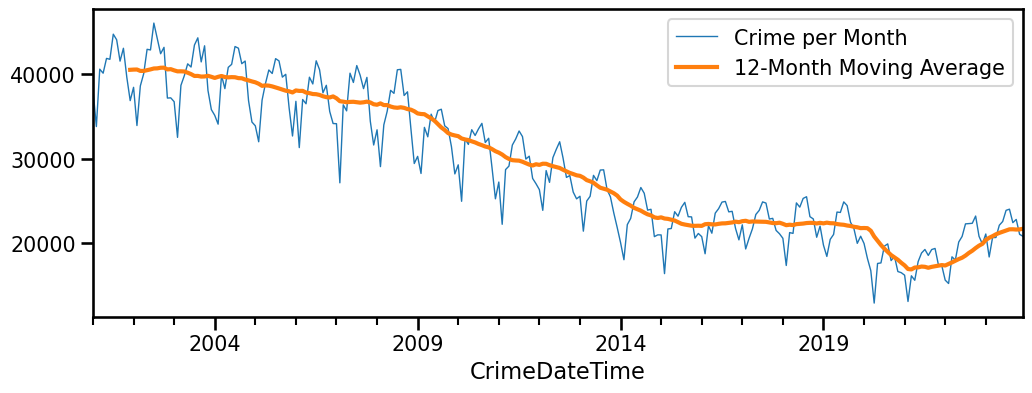

In [104]:
# Resample data to find Average Daily Crime Count per Month
df_ts = df.resample('MS').size()

# Rolling average over a number of months
window = 12
df_ts_mean = df_ts.rolling(window).mean()

# Plot Average Daily Counts per Month & Moving Average
ax = df_ts.plot(label='Crime per Month', lw=1, figsize=(12,4))
df_ts_mean.plot(label=f'{window}-Month Moving Average', ax=ax, lw=3)
ax.legend();

We can see that the average total of crime has been decreasing from 2003 to 2021. The average crime rate essentially halved from 2002 rates by 2020 (during COVID). After 2021, there seems to be a slight rebound in crime, back to 2015-2019 levels, after a dip for about three years during 2020-2022.

### Individual Crime Trends: New DataFrame with Total Crime by Category per Month

In [105]:
# Preview total number of crimes by category from 2001 through 2023
with pd.option_context('display.max_rows', None):
    print(df.groupby('Primary Type').size().apply(K_delim))

Primary Type
ARSON                            13,630
ASSAULT                         523,684
BATTERY                       1,455,020
BURGLARY                        429,690
CRIMINAL DAMAGE                 908,966
CRIMINAL TRESPASS               217,578
DECEPTIVE PRACTICE              357,814
GAMBLING                         14,631
HOMICIDE                         13,022
MOTOR VEHICLE THEFT             395,777
NARCOTICS                       751,474
NON-CRIMINAL                        231
OFFENSE INVOLVING CHILDREN       64,436
OTHER OFFENSE                   514,627
PROSTITUTION                     69,961
PUBLIC PEACE VIOLATION           71,739
ROBBERY                         300,726
SEX OFFENSE                      68,528
STALKING                          5,174
THEFT                         1,684,206
WEAPONS VIOLATION               113,741
dtype: object


In [106]:
# 1. get list of unique crime descriptions
crime_list = df["Primary Type"].unique()
crime_list

array(['SEX OFFENSE', 'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'THEFT',
       'BATTERY', 'BURGLARY', 'OTHER OFFENSE',
       'OFFENSE INVOLVING CHILDREN', 'ASSAULT', 'MOTOR VEHICLE THEFT',
       'WEAPONS VIOLATION', 'CRIMINAL TRESPASS', 'ROBBERY', 'NARCOTICS',
       'PUBLIC PEACE VIOLATION', 'STALKING', 'HOMICIDE', 'GAMBLING',
       'PROSTITUTION', 'ARSON', 'NON-CRIMINAL'], dtype=object)

In [107]:
# 2. Create a new empty dictionary  
CRIMES = {}

In [108]:
# 3. Loop through the list of crimes
for crime in crime_list:
    
    # I. Save a temp df of just the rows that match the crime
   temp = df.loc[ df["Primary Type"]==crime].copy()

    # II. RESAMPLE the temp DataFrame as Monthly data (crime counts) 
    # and keep ONLY the .size() 
   temp_res = temp.resample("MS").size() 

   # III. Save the temporary DataFrame in the dictionary,
   # using the crime description as the key.
   CRIMES[crime] = temp_res.copy() 
    
# CRIMES is now resampled as monthly
CRIMES.keys()

dict_keys(['SEX OFFENSE', 'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'THEFT', 'BATTERY', 'BURGLARY', 'OTHER OFFENSE', 'OFFENSE INVOLVING CHILDREN', 'ASSAULT', 'MOTOR VEHICLE THEFT', 'WEAPONS VIOLATION', 'CRIMINAL TRESPASS', 'ROBBERY', 'NARCOTICS', 'PUBLIC PEACE VIOLATION', 'STALKING', 'HOMICIDE', 'GAMBLING', 'PROSTITUTION', 'ARSON', 'NON-CRIMINAL'])

In [109]:
# 4. convert CRIMES dictionary to a crimes dataframe 
crimes_df = pd.DataFrame(CRIMES)
crimes_df.head(3)

,SEX OFFENSE,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,THEFT,BATTERY,BURGLARY,OTHER OFFENSE,OFFENSE INVOLVING CHILDREN,ASSAULT,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,PUBLIC PEACE VIOLATION,STALKING,HOMICIDE,GAMBLING,PROSTITUTION,ARSON,NON-CRIMINAL
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,
2001-01-01,387,1398,3966,7867,6527,1934,2921,321,2123,2097,337,1192,1396,4715,197,26,42,44,563,67,NaN
2001-02-01,286,1163,3665,6669,6042,1666,2621,210,2029,1785,301,1063,1159,4369,200,13,27,37,426,57,NaN
2001-03-01,340,1313,4618,7766,7662,1832,3007,267,2824,2152,345,1141,1399,4862,289,17,37,55,550,93,NaN


In [110]:
# 5. Replace all NaN values with a zero value, and convert all float/decimal values into type integer.
crimes_df = crimes_df.fillna(0).astype(int)
crimes_df.head(3)

,SEX OFFENSE,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,THEFT,BATTERY,BURGLARY,OTHER OFFENSE,OFFENSE INVOLVING CHILDREN,ASSAULT,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,PUBLIC PEACE VIOLATION,STALKING,HOMICIDE,GAMBLING,PROSTITUTION,ARSON,NON-CRIMINAL
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,
2001-01-01,387,1398,3966,7867,6527,1934,2921,321,2123,2097,337,1192,1396,4715,197,26,42,44,563,67,0
2001-02-01,286,1163,3665,6669,6042,1666,2621,210,2029,1785,301,1063,1159,4369,200,13,27,37,426,57,0
2001-03-01,340,1313,4618,7766,7662,1832,3007,267,2824,2152,345,1141,1399,4862,289,17,37,55,550,93,0


In [111]:
# 6. verify time series frequency (MS/Month Start), count (272), data type (integer)
crimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 2001-01-01 to 2023-12-01
Freq: MS
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   SEX OFFENSE                 276 non-null    int64
 1   DECEPTIVE PRACTICE          276 non-null    int64
 2   CRIMINAL DAMAGE             276 non-null    int64
 3   THEFT                       276 non-null    int64
 4   BATTERY                     276 non-null    int64
 5   BURGLARY                    276 non-null    int64
 6   OTHER OFFENSE               276 non-null    int64
 7   OFFENSE INVOLVING CHILDREN  276 non-null    int64
 8   ASSAULT                     276 non-null    int64
 9   MOTOR VEHICLE THEFT         276 non-null    int64
 10  WEAPONS VIOLATION           276 non-null    int64
 11  CRIMINAL TRESPASS           276 non-null    int64
 12  ROBBERY                     276 non-null    int64
 13  NARCOTICS                   276 non-n

### Individual Crime Trends: Via Seasonal Decomposition

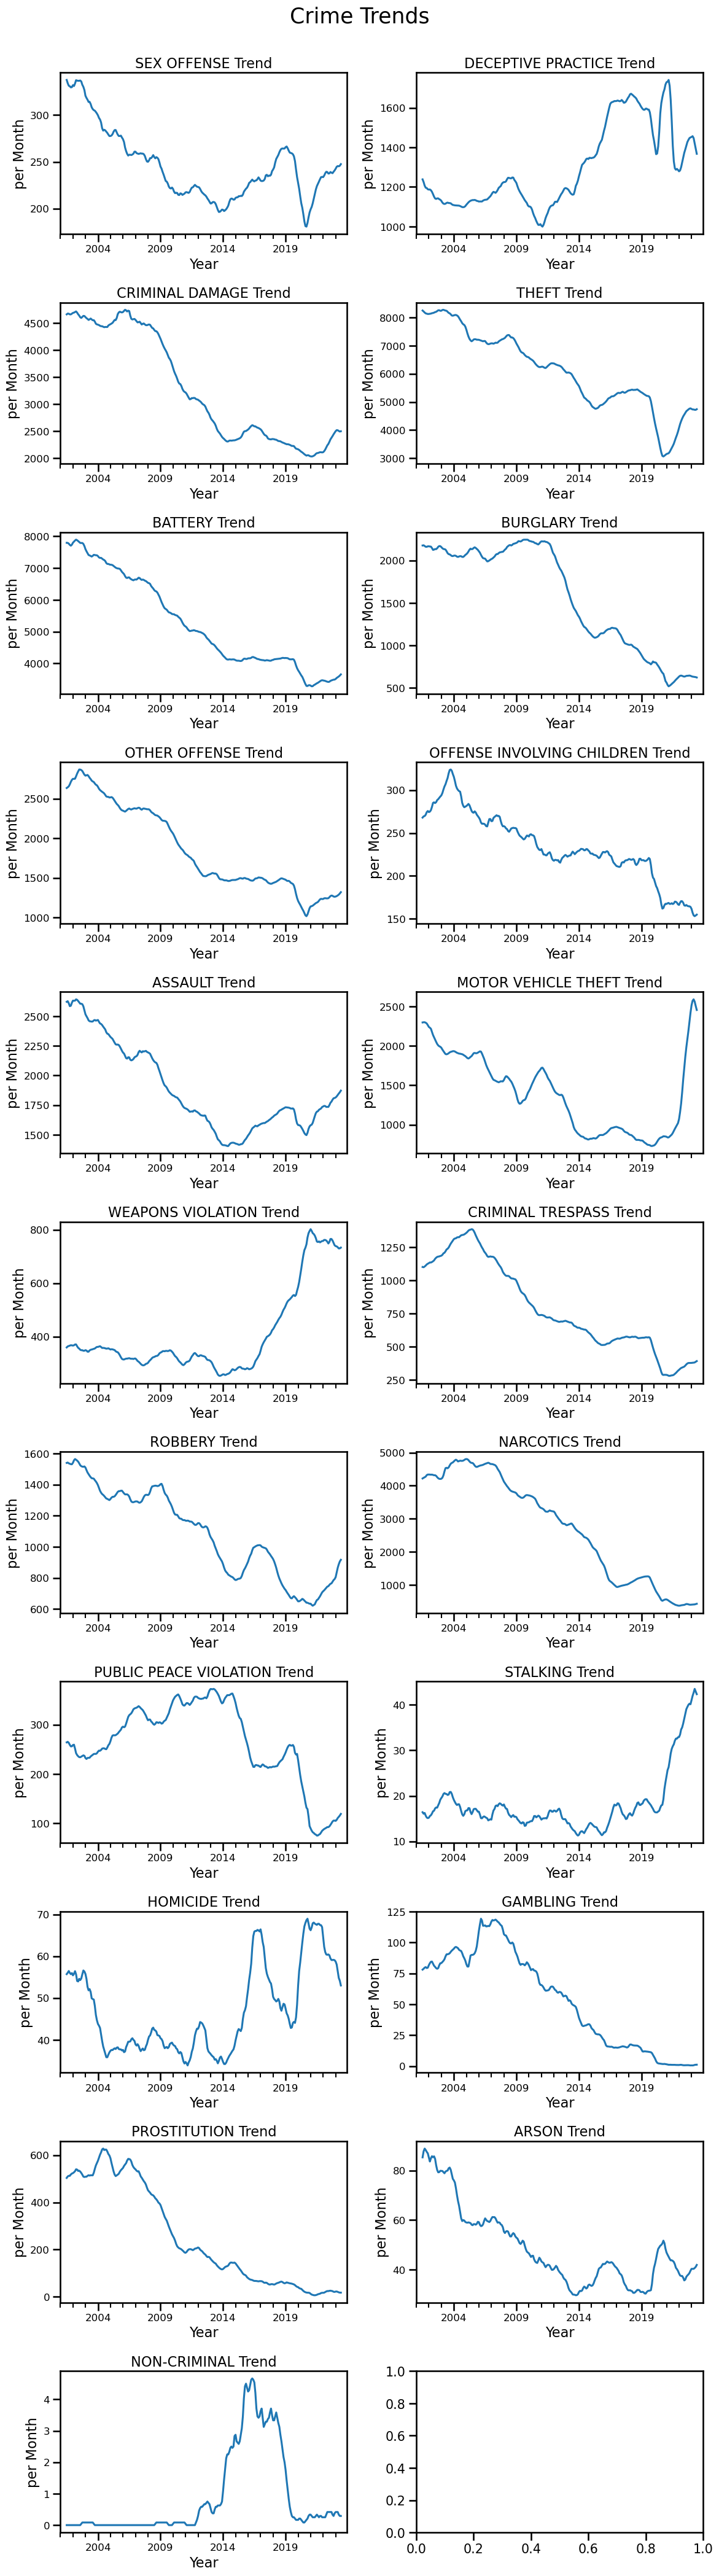

In [112]:
## Plot Monthly Crime Trends for all crimes
# Source: https://stackoverflow.com/questions/64229894/how-to-fix-numpy-ndarray-object-has-no-attribute-get-figure-when-plotting-su

# Instantiate values to size figure
plot_length = len(crimes_df.columns)
max_row = math.ceil(plot_length/2)
max_col = 2

# Set figure dimension and layout of subplots
fig, axes = plt.subplots(max_row, max_col, figsize=(12, plot_length*2))

# Flatten array of axes to have a single group of multiple subplots vs multiple groups
axe = axes.ravel()

# Iterate over columns 
for i, c in enumerate(crimes_df.columns):
        
    # create seasonal decomposition for each column
    decomp = tsa.seasonal_decompose(crimes_df.iloc[:,i])
    
    # extract "Trend" to plot for each crime type
    decomp.trend.plot(title=f'{c} Trend', ax=axe[i], xlabel="Year", ylabel="per Month", fontsize=12)
    

fig.suptitle('Crime Trends', fontsize=25, y=1)

fig.tight_layout()

We saw in the "Overall Crime Trend" Section, that according to the dataset, crime decreased by 50% by 2020 from 2002 rates. The average total of crimes decreased from 2002 to 2021, with a slight dip and recovery during COVID from 2021 to 2023. 

Looking at the categorical crime trends above, most of the rest follow the same general trend of decreasing crime rates between 2022 and 2020. But there are some exceptions. 

The most clear exceptions go from *stable levels* to very high levels by 2023. These include the following:

> * Weapons Violation
> * Stalking

Some others had a large peak in the middle of our time frame, then dropping from its peak, but still at a higher level than in 2001. This includes:

> * Deceptive Practice

Similarly, some had peaks and/or valleys in the middle of our time time frame, but returned to levels similar to what they were in 2001. These include:

> * Motor Vehicle Theft
> * Homicide
> * Non-Criminal

Of special note, a few categories experienced a **dramatic increase** in rates during pre-COVID/COVID, around **250%** for each one, with *Motor Vehicle Theft* being the most striking increase within a single year. Ranked from highest in frequency, they are:

> * Motor Vehicle Theft (~1 year!)
> * Weapons Violation   (~4 years)
> * Stalking            (~3 years)

## Comparing Months:
What months have the most crime? What months have the least?

Are there any individual crimes that do not follow this pattern? If so, which crimes?


### Total Crime Average by Month

In [113]:
# Count total number of crime types/categories
total_crime_count = len(crimes_df.columns)
total_crime_count

21

In [114]:
# Create 'Total Crime' column for binning
crimes_df['Total Crime'] = crimes_df.iloc[:, range(len(crimes_df.columns))].sum(axis =1)
crimes_df.head(3)

,SEX OFFENSE,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,THEFT,BATTERY,BURGLARY,OTHER OFFENSE,OFFENSE INVOLVING CHILDREN,ASSAULT,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,PUBLIC PEACE VIOLATION,STALKING,HOMICIDE,GAMBLING,PROSTITUTION,ARSON,NON-CRIMINAL,Total Crime
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,387,1398,3966,7867,6527,1934,2921,321,2123,2097,337,1192,1396,4715,197,26,42,44,563,67,0,38120
2001-02-01,286,1163,3665,6669,6042,1666,2621,210,2029,1785,301,1063,1159,4369,200,13,27,37,426,57,0,33788
2001-03-01,340,1313,4618,7766,7662,1832,3007,267,2824,2152,345,1141,1399,4862,289,17,37,55,550,93,0,40569


In [115]:
# Extract month name & number as new columns
crimes_df['Month'] = crimes_df.index.month
crimes_df['MonthName'] = crimes_df.index.month_name()
crimes_df.head(3)

,SEX OFFENSE,DECEPTIVE PRACTICE,CRIMINAL DAMAGE,THEFT,BATTERY,BURGLARY,OTHER OFFENSE,OFFENSE INVOLVING CHILDREN,ASSAULT,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,PUBLIC PEACE VIOLATION,STALKING,HOMICIDE,GAMBLING,PROSTITUTION,ARSON,NON-CRIMINAL,Total Crime,Month,MonthName
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,387,1398,3966,7867,6527,1934,2921,321,2123,2097,337,1192,1396,4715,197,26,42,44,563,67,0,38120,1,January
2001-02-01,286,1163,3665,6669,6042,1666,2621,210,2029,1785,301,1063,1159,4369,200,13,27,37,426,57,0,33788,2,February
2001-03-01,340,1313,4618,7766,7662,1832,3007,267,2824,2152,345,1141,1399,4862,289,17,37,55,550,93,0,40569,3,March


In [116]:
# Save lookup for number vs name
unique_months = crimes_df.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup = dict(zip(unique_months['Month'], unique_months['MonthName']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

### Total Crime Average by Month: Graph

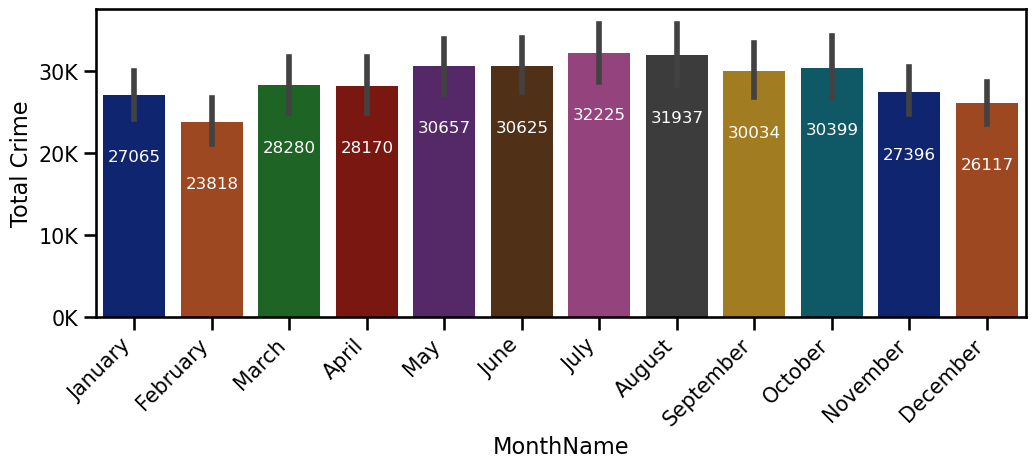

In [117]:
ax = sns.barplot(data=crimes_df, y='Total Crime', x='MonthName', palette='dark', 
                 order=month_lookup.values());

# Source: https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
ax.bar_label(ax.containers[0],fmt = '%.0f', fontsize=12, padding=-50, color='white')  

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha= 'right');
ax.yaxis.set_major_formatter(mticks.FuncFormatter(thousands))
fig.tight_layout()

We can see the average total crime per month.

Highest Total Average: 
> * July
> * 32,225

Lowest Total Average:
> * February
> * 23,818

We can see that there is about a 30% difference in crime rates between the lowest and highest months. Assuming that February is the coldest month and that July is the hottest month, we can project that the temperature/season seems to have a pronounced effect on crime rates in Chicago. 

### Individual Crime Averages by Month: Graphs

Are there any individual crimes that do not follow this pattern? If so, which crimes?

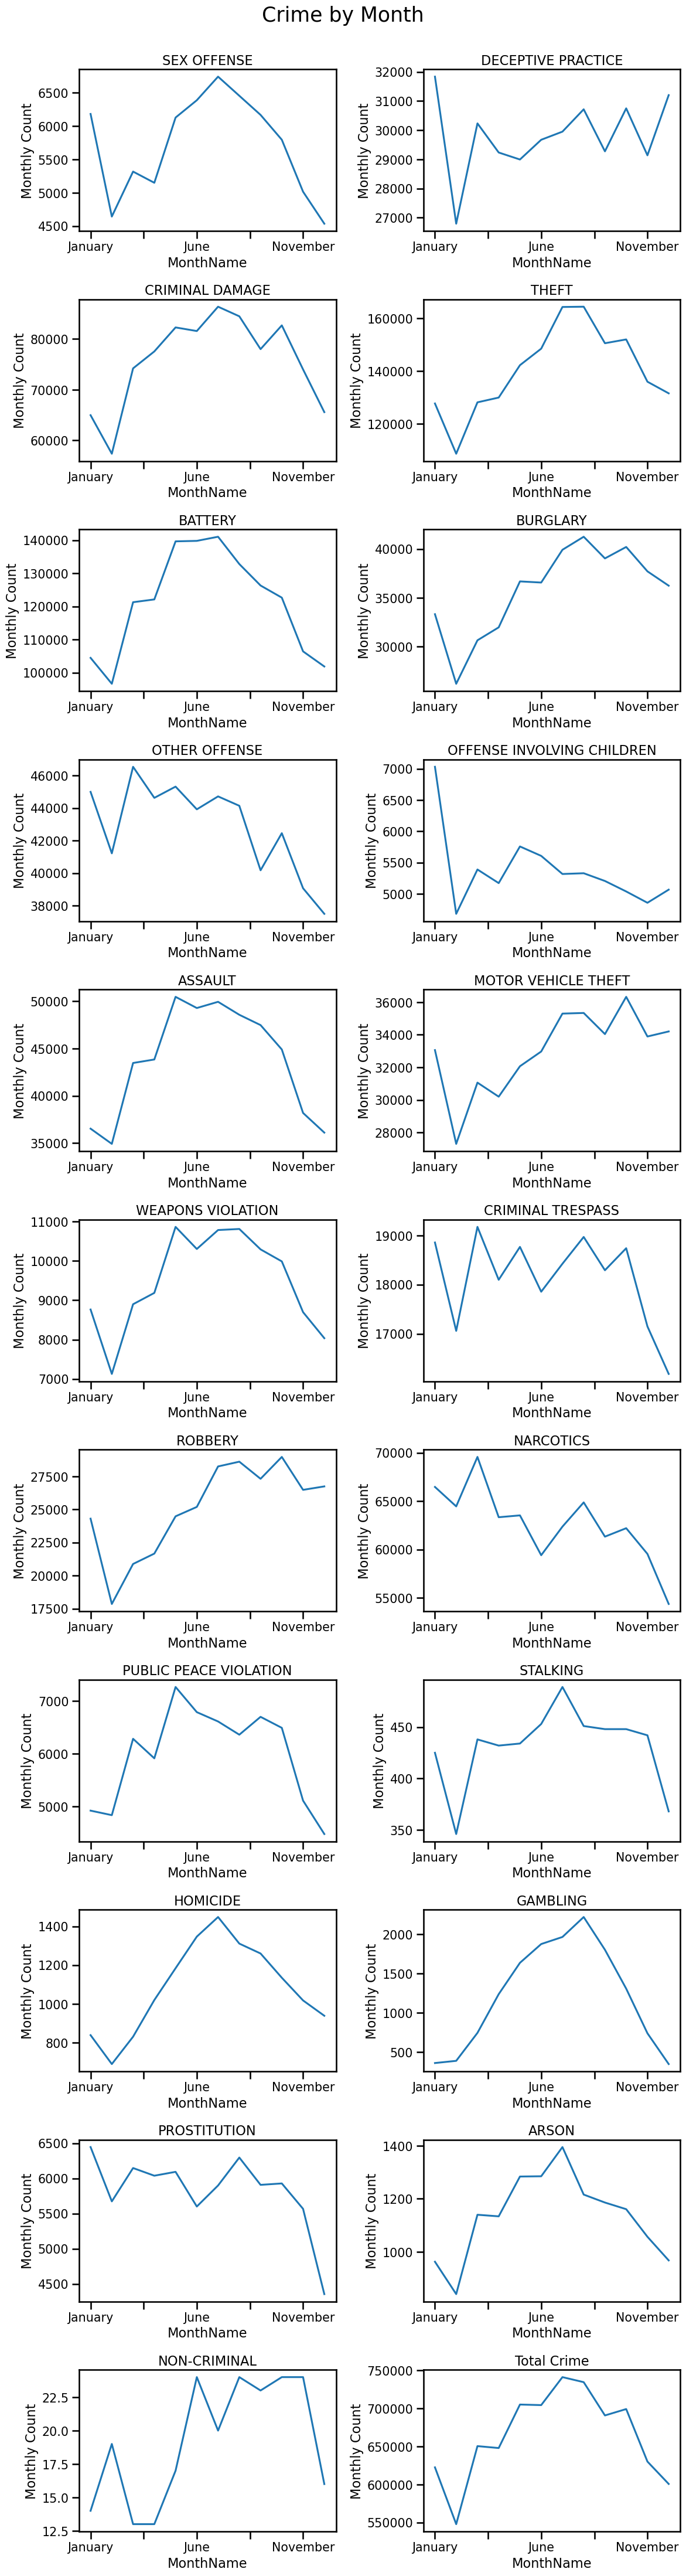

In [118]:
## Plot Monthly Crime Trends for all crimes
# Source: https://stackoverflow.com/questions/64229894/how-to-fix-numpy-ndarray-object-has-no-attribute-get-figure-when-plotting-su

# Instantiate values to size figure
plot_length = len(crimes_df.columns[:-2])
max_row = math.ceil(plot_length/2)
max_col = 2

# Set figure dimension and layout of subplots
fig, axes = plt.subplots(max_row, max_col, figsize=(12, plot_length*2))

# Flatten array of axes to have a single group of multiple subplots vs multiple groups
axe = axes.ravel()

# Iterate over columns 
for i, c in enumerate(crimes_df.columns[:-2]):
   
    crimes_df.groupby('MonthName', sort=False)[c].sum().plot(ax=axe[i], title=c, ylabel="Monthly Count")
  

fig.suptitle('Crime by Month', fontsize=25, y=1)

fig.tight_layout()

Most individual crimes follow the general trend of having  <br>
*highest* rates in **summer** (~July),    <br>
*lowest* rates in **winter** (~February).

A few exceptions are:

max: January <br>
min: February:
> * Offense Involving Children 
> * Deceptive Practice 

max: January <br>
min: December:
> * Prostitution

max: March  <br>
min: December:
> * Other Offense 
> * Criminal Trespass 
> * Narcotics 

# Summary

Overall, crime is about half of what is was 20 years ago, which is a great improvement.

* Crime rate dropped around 50% from 2002 to 2022.
* Crime rate dipped, then recovered, during COVID from 2020 to 2023.

In contrast, Motor Vehicle Theft has more than doubled in the last year, or so.
* Motor Vehicle Theft increased drastically at the end of COVID (within ~12 months), by around 250%.

Temperature/Season seems to have a 30% affect on crime rates. 
* Crime rates are lowest when it is coldest.
* Crime rates are highest when it is hottest.

# Insights & Recommendations

While overall crime is down in Chicago since the last two decades, there will always be some crime. Always be aware of your surroundings and how others might be able to take advantage of you or your situation.

Crime averages 30% higher in the hottest months, compared to the coldest. When the season is hot and the temperatures are high, keep your cool and help others to do the same. 

Car Theft, Weapons Violations and Stalking have all more than doubled from their lows a few years ago. 

* For your vehicle, follow recommended preventative methods to keep it safe. 
* For weapons, be aware that there are more weapons in places they should not be and/or in the hands of people who should not have them.
* For stalking, follow recommended methods to get the security, safety and support needed.


# Export Results to File

In [119]:
# Export dataframe to a CSV file

# Specify file name and include datetime index column for CSV file 
df.to_csv('Data/Chicago/Crimes_-_2001_to_2023_processed.csv', index=True)

# Serialize Results to File

Use joblib to serialize data and variables after data cleaning and processing.

In [120]:
# serialize results to a file: future

# create dictionary with variables to save for later
export = {
    'df': df,
    'geo_df': geo_df,
    'geometry': geometry,
    'street_map': street_map,
    'true_indexes': true_indexes  #'key_name1': key_value1,
    }

# save dictionary as a file
joblib.dump(export, 'Chicago_Crime_export')

# import joblib file with serialized variables
loaded_data = joblib.load('Chicago_Crime_export')

# display keys to use to save to new/active variables
loaded_data.keys()

/Users/whitefreeze/anaconda3/envs/dojo-env/lib/python3.9/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


dict_keys(['df', 'geo_df', 'geometry', 'street_map', 'true_indexes'])

The dataframe has been successfully exported as a CSV file and the indicated variables/data have had their final states serialized and saved as a joblib file (the variables/data can be simply imported instead of having to rerun all of the code again after the kernel has been terminated).